<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 2: Epidemieausbreitung
</b></p>
<p style="font-size:25px; color: #3776ab; text-align:center">
Populationsdynamik & Netzwerke
</p>
<br>
<p style="font-size:15px; text-align:center">
von Lorenz Saalmann (8104072), Jonathan Fimmen (2044799) und Peter Preisler (8102359)
<br>begleitet durch Leon Sieke
</p>
<br>

# Inhaltsverzeichnis

1. Einführung
2. Verwendetes Modell
3. Grundlegende Implementation
4. Test des Grundmodells
5. Erweiterung des Modells
6. Tote, Inkubationszeit und Wiederansteckung
7. Asymptomatische Verläufe und Maßnahmen
8. Weltweite Ausbreitung
9. Fazit

# 1. Einführung

Das Jahr 2020 wird für zukünftige Generationen wohl fest mit der Covid-19-Pandemie verbunden sein. Die globalisierte Welt in Verbindung mit einem passend ausgestatteten Virus haben dafür gesorgt, dass das öffentliche Leben zeitweise nahezu vollständig eingestellt werden musste, um die Ausbreitung aufzuhalten. Dadurch wurde der Menschheit aufgezeigt, wie wichtig es ist die Ausbreitungsdynamik beliebiger Krankheiten zu verstehen. Denn nur dann können passende und wirksame Maßnahmen getroffen werden, um den Verlauf zu kontollieren. Da sich unglaublich viele Faktoren auf diese Dynamik auswirken, sollten Vorbereitungen getroffen werden um möglichst realistische Modelle zu entwickeln. 

In dieser Arbeit werden zwei Modelle miteinander kombiniert. Die Ansteckungen werden mithilfe des SIR-Modells (Susceptible-Infected-Recovered) beschrieben, während die Reisebewegungen unter Verwendung eines Diffusionsmodells eingebracht werden. Die daraus resultierenden Differentialgleichungen werden im nächsten Kapitel diskutiert. Mit dem Modell soll anschließend die Ausbreitung einer Infektionskrankheit in Europa beschrieben werden, wobei die Flughäfen mit ihren Einzugsgebieten in der SIR-Dynamik eine Identität darstellen, welche durch das Diffusionsmodell miteiander in Verbidnung stehen. Im weiteren Verlauf wird das erstellte Modell erweitert um es noch näher an die Realität anzupassen.

# 2. Verwendetes Modell

## 2.1 SIR-Modell

Wie der Name nahelegt unterscheidet das grundlegende Modell drei verschiedene Gruppen. Einmal die ansteckbare Bevölkerung $S(t)$ (Suceptible), welche durch die Krankheit infiziert werden kann. Dann die infizierte Gruppe $I(t)$ (Infected), welche derzeit mit der Krankheit infiziert ist. Und schließlich die genesenen Personen $R(t)$ (Recovered), welche nicht mehr von der Krankheit befallen und jetzt immun sind. Dabei wird zunächst nicht unterschieden, ob diese gestorben sind, oder sie die Krankheit besiegt haben. Es ergeben sich folgende Differentialgleichungen (wobei $N=S+I+R$, weshalb auch $N(t)$):

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S I}{N},\tag{1}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \beta \frac{S I}{N} -\gamma I,\tag{2}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I\tag{3}
\end{align}

Der Parameter $\beta$ gibt dabei die Ansteckungsrate an, welche sich aus der Wahrscheinlichkeit für eine Ansteckung ergibt. Diese ist sowohl vom Virus selbst, als auch von der Exposition der Infizierten Bevölkerung abhängig.
Die Übergangsrate $\gamma$ ist hingegen durch die Inverse der durchschnittlichen Dauer der Krankheit definiert. Sie bestimmt wie schnell sich infizierte Personen wieder von der Krankheit erholen (oder sterben).

## 2.2 Diffsionsmodell

Die Grundlage des Diffusionsmodell bilden - wie oben bereits erwähnt - die Flughäfen Europas und ihre Verbindungen untereinander. Zwischen diesen Flughäfen werden Reisen der jeweiligen Gruppen modelliert. Die Diffentialgleichungen erweitern sich dadurch zu:

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = D_S \nabla^2 S -\beta \frac{S I}{N},\tag{4}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = D_I \nabla^2 I + \beta \frac{S I}{N} -\gamma I,\tag{5}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = D_R \nabla^2 R + \gamma I,\tag{6}
\end{align}

Die Diffusionskonstanten $D_S$, $D_I$ und $D_R$ werden zunächst als identisch angenommen. Da das betrachtete Netzwerk diskret ist ergibt sich der Laplaceoperator als:

\begin{equation}
    \nabla^2 C_i(t) = \sum_{j\sim\, i}^{\mathrm{deg}(i)}\frac{\bigl[C_j(t) - C_i(t)\bigr]}{{\mathrm{deg}(i)}},\quad \text{mit } C \in \{S, I, R\}.\tag{7}
\end{equation}

Der Normierungsfaktor $\frac{N_i}{N_j}$ findet Anwendung, da sich die Populationen der Städte unterscheiden. Ohne ihn würden sich mit der Zeit die Einwohnerzahlen aller Städte auf einen Mittelwert zubewegen.

In der folgenden Implementation wird zudem angenommen, das Reisen instantan ablaufen und auf ihnen keine Ansteckungen möglich sind. Deshalb können die Differentialgleichungen für SIR-Dynamik und Diffusionsmodell separat voneinander gelöst werden.

## 2.3 Diskussion des Modells

Das SIR-Modell beschreibt auf eine relative einfache Art einen Epidemieverlauf. Mit nur drei Personengruppen und zwei Parametern, welche die Wechselwirkungen beschreiben, ist es dem Modell möglich, einen groben Verlauf der Ausbreitung zu visualisieren. Die Faktoren $\beta$ und $\gamma$ sind dabei sehr vielfältig einsetzbar und können hinsichtlich vieler Faktoren modifizert werden. Die isolierte Darstellung einzelner Faktoren wie z.B. Bevölkerungsdichte, Klima oder sozialer Isolation ist aufgrund der wenigen Simulationsparameter schwer zu realisieren. Ebenso setzt das Modell eine homogene Bevölkerung, sowie eine gleichmäßige Krankheitsausbreitung vorraus. In der Realität spielen viele Faktoren wie Jahreszeit, Durchschnittsalter der Bevölkerung oder Mutationen des Krankheiterregers eine Rolle.

Um eine realistische Epidemiesimulation zu erhalten bedarf es unterschiedlicher Erweiterungen des Modells, welche die Komplexität der Dynamik angebracht darstellen. 

# 3. Grundlegende Implementation

## 3.1 Grundaufbau 

Import aller notwendigen Pakete.

In [1]:
import pandas as pd # Datenverarbeitung
import numpy as np  # Numerische Berechnungen
import matplotlib.pyplot as plt # Visualisierung
from matplotlib.animation import FuncAnimation # Animations
from IPython.display import Image, clear_output # Load Animations
import cartopy.crs as ccrs # Kartenprojektionen
from scipy.integrate import solve_ivp # Numerische Lösung von Differentialgleichungen

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Die grundlegenden Datensätze werden in aufbereiteter Form zur Verfügung gestellt und nun importiert.

In [2]:
# import all cleaned data
airports = pd.read_csv('./datasets/cleaned_data/airports_cleaned.csv')
routes = pd.read_csv('./datasets/cleaned_data/routes_cleaned.csv')
routes_matrix = pd.read_csv('./datasets/cleaned_data/routes_matrix_cleaned.csv', index_col=0)

Erstellen der Klasse 'City', welche den momentanten Zustand einer Stadt in Hinsicht auf das SIR-Modell beinhaltet. Sie bietet zudem die Möglichkeit die Stadt mit einer Krankheit zu infizieren, oder alle Werte auf den Ausgangszustand zurückzusetzen.

In [3]:
# data class to hold infection values
class City:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.S = population
        self.I = 0
        self.R = 0
    # infects a given percent of all suceptible people
    def infect_percent(self, percent):
        self.I += self.S * percent
        self.S = self.S - self.S * percent
    # infects a total number of suceptible people
    def infect(self, newly_infected):
        self.I += newly_infected
        self.S = self.S - newly_infected
    # resets the sir-dynamic     
    def reset_city(self):
        self.S = self.population
        self.I = 0
        self.R = 0

Anschließend wird ein Dictionary erstellt, welches jedem IATA-Code die zugehörige Stadt der Klasse City zuordnet und mit den Ausgangswerten füllt. 

Für die späteren Tests der Implementation wird zugleich eine Funktion definiert, welche alle Städte auf den Ausgangszustand zurücksetzt.

In [4]:
# create a dict with iata to cities
cities = {}
for airport in (airports[['population', 'IATA']]).values:
    cities[airport[1]] = (City(airport[0], airport[1]))
 
def cure_humanity():
    # resets the sir-dynamic for all cities
    for c in cities.values():
        c.reset_city()

Es wird eine Funktion definiert die den zeitlichen Verlauf der SIR-Dynamik einer beliebigen Stadt als Plot darstellt. Dabei werden bereits einige Gruppen berücksichtigt, welche erst im erweiterten Modell betrachtet werden.

In [5]:
def plot_SIR(title, t, s=[], i=[], r=[], z=[], d=[], n=[], a=[], close=-1, open=-1, values = {}, plot=True):
    # Plot SIR values
    if plot:
        plt.close()

    if (len(s) > 0):
        plt.plot(t, s, label='Susceptable')
    if (len(i) > 0):
        plt.plot(t, i, c='red', label='Infected')
    if (len(r) > 0):
        plt.plot(t, r, c='green', label='Recovered')
    if (len(z) > 0):
        plt.plot(t, z, c='purple', label='Incubation')
    if (len(d) > 0):
        plt.plot(t, d, c='black',label='Dead')
        total_d = int(d[-1])
        plt.figtext(.5,-.05,f'Total Deaths: {total_d}', fontsize=8, ha='center')
    if (len(a) > 0):
        plt.plot(t, a, c='orange', label='Asymptomatic')
    if (len(n) > 0):
        plt.plot(t, n, label='Total')
    if (close != -1):
        plt.plot(t,[close]*len(t), '--', c='black', markersize = .2, label='Airport Shutdown')
    if (open != -1):
        plt.plot(t,[open]*len(t), '--', c='gray', markersize = .2, label='Airport Reopening')
    plt.xlabel('Days')
    plt.ylabel('Number of People')
    plt.title(title)

    subtitle = ''
    for x, v in enumerate(values):
        if x != 0:
            subtitle += ',  '
        subtitle += fr'${v} = {round(values[v],2)}$'
    
    if plot:
        plt.legend()
        # show all values provided underneath
        plt.figtext(.5,-.015, subtitle, fontsize=8, ha='center')
        plt.show()
    else:
        y = max(i)
        x = i.index(y)
        plt.annotate(subtitle, [x,y + 10])

Außerdem wird eine Funktion definiert, mit der die Infektionszahlen in ganz Europa auf einem Plot dargestellt werden können.

In [6]:
def plot_global_values (title, t, values):
    global_values = []
    # build sum over all values from each city for each timestep
    for x in range(len(t)): 
        for i, v in enumerate(values.values()):
            sums = v[x] if i == 0 else tuple(map(lambda x, y: x + y, sums, v[x]))
        global_values.append(sums)

    n = len(global_values[0])
    if n == 3:
        S, I, R = zip(*global_values)
        plot_SIR(f"{title}", t, S, I, R)
    if n == 5:
        S, Z, I, D, R = zip(*global_values)
        plot_SIR(f"{title}", t, S, I, R, Z, D)
    if n == 7:
        S, Z, A, I, D, R, C = zip(*global_values)
        plot_SIR(f"{title}", t, S, I, R, Z, D, a=A)
        if (max(C) == 0):
            return
        plt.plot(t,C)
        plt.xlabel('Days')
        plt.ylabel('Number of closed airports')
        plt.show()

## 3.2 Diffusionsmodell

Die 'routes_matrix' enthält die nach dem Alphabet sortierten IATA-Codes aller verwendeten Städte jeweils als Zeilen- und Spaltenindizes. An jedem Verknüpfungspunkt zwischen einer Stadt aus Zeile und Spalte steht eine 1, wenn zwischen beiden eine direkte Verbindung besteht, oder eine 0, wenn keine vorhanden ist. Aus diesem Grund ist die Matrix symmetrisch. 

Der Funktion wird eine Stadt übergeben, von welcher die Difussion zu allen direkt angebundenen Städten berechnet werden soll. Zudem erhält die Funktion die Diffusionskonstanten $D_S$, $D_I$ und $D_R$ als Übergabeparameter. Anschließend wird die, der übergebenen Stadt zugehörigen, Spalte in der Matrix mit einer for-Schleife durchlaufen. Immer wenn eine Verbindung zu einer korrespondierenden Stadt besteht, wird die zugehörige Diffusion ausgerechnet und aufsummiert.

In [7]:
def calculate_travel (ci : City, ds, di, dr):
    # Calculate a travel step for given city
    sumS = 0
    sumI = 0
    sumR = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue

        iata = routes_matrix.index[i]

        cj = cities[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R
    
    return (ds * sumS / i, di * sumI / i, dr * sumR / i)

## 3.3 SIR-Modell

### 3.3.1 Implementation der drei Algorithmen

Nun sollen mit drei verschiedenen Algorithmen die Differentialgleichungen des SIR-Modells gelöst werden. 

Das einfachste Verfahren, welches sich zur Lösung anbietet, ist das Euler-Verfahren. Bei diesem wird der Funktionswert an der Stelle $t_1$ aus der Tangentensteigung bei $t_0$ bestimmt. Dazu wird die Steigung (Ableitung an der Stelle $t_0$) mit einem Zeitschritt multipliziert, um die absolute Änderung innerhalb des Zeitschritts zu erhalten. Addiert man diese Änderung auf den Funktionswert bei $t_0$ erhält man den nächsten Funktionswert. Diese Methode ist sehr simpel, weist dafür aber auch den größten Fehler auf, wie später zu erkennen ist.

In [9]:
def calculate_SIR_euler(c : City, beta, gamma, days):
    # solves the SIR differential equations within given city for given parameters
    N = c.population
    time_step = 1
    t = []
    s = []
    i = []
    r = []

    for d in range(days):
        # append values to list
        t.append(d)
        s.append(c.S)
        i.append(c.I)
        r.append(c.R)
        
        # calculate each step
        dS_dt = -beta / N * c.S * c.I
        dI_dt = beta / N * c.S * c.I - gamma * c.I
        dR_dt = gamma * c.I
        
        # add steps multiplied by timestep
        c.S += dS_dt * time_step
        c.I += dI_dt * time_step
        c.R += dR_dt * time_step
    
    return t, s, i, r

Ein genaueres Verfahren zu Lösung von Differentialgleichungen stellt der Runge-Kutta Algorithmus dar. Dieser Algorithmus baut auf dem Euler Verfahren auf und nutzt ebenso die lokale Änderungsrate $F(y,t)$ um den nächsten Funktionswert zu berechnen. Allerdings verbessert er die Genauigkeit, da er nicht nur die Steigung am Startpunkt, sondern drei weitere Stützpunkte verwendet.

Gehen wir von einer Steigung $F(y, t)$ im Startpunkt aus, erhalten wir den Punkt K1 nach Multiplikation mit dem Zeitschritt $\Delta t$. $K_2$ sowie $K_3$ lassen sich mithilfe des zuvor berechneten $K_{1,2}$ und der Formel $K_{2,3} = \Delta t \cdot F(y + \frac{K_{1,2}}{2}, t + \frac{\Delta t}{2})$ berechnen. Diese Punkte liegen also genau zwischen dem ursprünglichen Punkt und dem zu erreichenden Zeitschritt. Der letzte Wert $K_4$ liegt zeitlich bei $t + \Delta t$ und bildet sich aus $\Delta t \cdot F(y + K_3, t + \Delta t)$. Mitteln wir diese Werte nun mit einer doppelten Signifikanz von $K_2$ und $K_3$, erhalten wir unsere Approximation für $y(t + \Delta t)$. Die Gewichtung der vier Werte lässt sich aus der Taylor-Reihe bestimmen. Zusammengefasst ergeben sich folgende Formeln für den Algorithmus:

$K_1 = \Delta t \cdot F(y, t)$

$K_2 = \Delta t \cdot F(y + \frac{K_{1}}{2}, t + \frac{\Delta t}{2})$

$K_3 = \Delta t \cdot F(y + \frac{K_{2}}{2}, t + \frac{\Delta t}{2})$

$y_{n+1} = \frac{\Delta t}{6} \cdot (K_1 + 2\cdot K_2 + 2\cdot K_3 + K_4)$

Beispielhaft zeigen wir hier den Verlauf des Algorithmus' für $S(t)$:

$y(t+\Delta t) = \frac{1}{6} \cdot (K_1 + 2\cdot K_2 + 2\cdot K_3 + K_4)$

In [10]:
def calculate_SIR_runge_kutta(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters
    dt = 1
    
    t_values = np.zeros(days + 1)
    S_values = np.zeros(days + 1)
    I_values = np.zeros(days + 1)
    R_values = np.zeros(days + 1)
    
    # initial conditions
    t_values[0] = 0
    S_values[0] = c.S
    I_values[0] = c.I
    R_values[0] = c.R

    b_over_n = beta / c.population
    
    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    for i in range(days):
        t = t_values[i]
        S = S_values[i]
        I = I_values[i]
        R = R_values[i]

        # Runge Kutta to the 4th order
        k1_S, k1_I, k1_R = derivatives(S, I) * dt
        k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
        k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
        k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
        # update the solution
        t_values[i+1] = t + dt
        S_values[i+1] = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
        I_values[i+1] = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
        R_values[i+1] = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    
    return t_values, S_values, I_values, R_values


Zuletzt findet die mächtige Funktion 'solve_ivp' aus der scipy-Bibliothek Anwendung. Für diese müssen lediglich die Ableitungen definiert und der Funktion übergeben werden; den Rest erledigt der interne Algortihmus.

In [11]:
def calculate_SIR_ivp(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters

    def derivatives(t, state):
        S = state[0]
        I = state[1]
        
        N = c.population
        
        dS_dt = -beta / N * S * I
        dI_dt = beta / N * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]
    
    return solve_ivp(derivatives, [0, days], [c.S, c.I, c.R], max_step=1)

### 3.3.2 Vergleich der Algorithmen

Vergleicht man die drei Verfahren, so erkennt man, dass das Runge-Kutta-Verfahren und die Funktion Solve_IVP identische Ergebnisse liefern. Das Euler-Verfahren weicht hingegen stark von den anderen beiden Verläufen ab. Die Genauigkeit sinkt insbesondere für niedrige initiale Infektionszahlen und geringe Ansteckungsraten $\beta$. Außerdem ist im Output der folgenden Zelle zu sehen, dass die manuell erstellten Verfahren deutlich schneller als die Funktion Solve_IVP ablaufen.

Euler took 0.0ms
Runge Kutta took 0.0ms
Solve IVP took 9.510993957519531ms


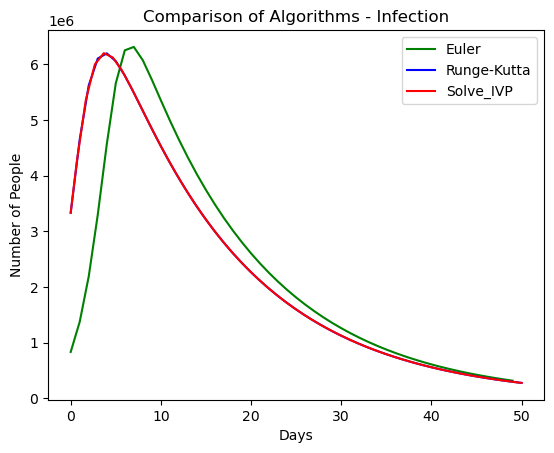

In [12]:
import time
# infect people - intial condition
test_city = cities['LHR']
test_city.reset_city()
test_city.infect_percent(.1)
beta = 0.8
gamma = 0.07
days = 50

plt.close()
# plot euler
ti = time.time()
t, s, i, r = calculate_SIR_euler(test_city, beta, gamma, days)
print(f'Euler took {(time.time() - ti)*1000}ms')
plt.plot(t, i, c='green', label='Euler')

# reset city again, because euler-method overwrites values
test_city.reset_city()
test_city.infect_percent(.4)

#plot runge-kutta
ti = time.time()
t, s, i, r = calculate_SIR_runge_kutta(test_city, beta, gamma, days)
print(f'Runge Kutta took {(time.time() - ti)*1000}ms')
plt.plot(t, i, c='blue', label='Runge-Kutta')

# plot ivp
ti = time.time()
sol = calculate_SIR_ivp(test_city, beta, gamma, days)
print(f'Solve IVP took {(time.time() - ti)*1000}ms')
plt.plot(sol.t, sol.y[1], c='red', label='Solve_IVP')

plt.xlabel('Days')
plt.ylabel('Number of People')
plt.title('Comparison of Algorithms - Infection')
plt.legend()
plt.show()

## 3.4 Kombination zum Basismodell

Für die kombinierte Simulation müssen zunächst, für alle drei Verfahren zur Lösung der SIR-Dynamik, Funktionen implementiert werden, welche genau einen Zeitschritt ausführen und die ihnen übergebene Stadt damit aktualisieren.

In [13]:
def step_euler(c : City, beta, gamma):
    # solves the SIR differential equations within given city for given parameters for 1 time step

    dt = 1
    b_over_n = beta / c.population

    # calculate one step
    dS_dt = -b_over_n * c.S * c.I
    dI_dt = b_over_n * c.S * c.I - gamma * c.I
    dR_dt = gamma * c.I
            
    # add steps multiplied by timestep
    c.S += dS_dt * dt
    c.I += dI_dt * dt
    c.R += dR_dt * dt
    
    return c


def step_RK(c : City, beta, gamma):
    # solve the SIR differential equations within given city for given parameters for 1 time step

    dt = 1
    b_over_n = beta / c.population

    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    S = c.S
    I = c.I
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_I, k1_R = derivatives(S, I) * dt
    k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
    k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
    k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c


def step_ivp(c : City, beta, gamma):
    # solve the SIR differential equations within given city for given parameters for one time step

    def derivatives(t, state):
        S = state[0]
        I = state[1]
        
        N = c.population
        
        dS_dt = -beta / N * S * I
        dI_dt = beta / N * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]
    
    sol = solve_ivp(derivatives, [0,1], [c.S, c.I, c.R], max_step = 1)

    c.S = sol.y[0][-1]
    c.I = sol.y[1][-1]
    c.R = sol.y[2][-1]
    
    return c

Die 'combined_simulation'-Funktion berechnet zuerst die lokale SIR Dynamik in einer Stadt und anschließend die Reisebewegung zwischen den Städten. Dabei kann beim Funktionsaufruf enschieden werden mit welchem Verfahren die SIR-Dynamik gelöst werden soll. Die S, I und R Werte werden für jeden Schritt in den Stadt-Objekten des cities Dictionary gespeichert. Um die Dynamik später auswerten zu können wird ein Dictionary zurückgegeben, welches jedem IATA-Code ein Array mit der kombinierten Dynamik der jeweiligen Stadt zuordnet.

In [14]:
def combined_simulation(beta, gamma, ds, di, dr, days, method):
    SIR_values = {}
    temp_values = {}
    for c in cities:
        SIR_values[c] = []
    t = [0]

    # add initial state
    for c in cities.values():
        SIR_values[c.IATA].append((c.S, c.I, c.R))
        
    for i in range(days):
        ti = time.time()
        # step SIR dynamic
        if method == "euler":
            for c in cities.values():
                c = step_euler(c,beta,gamma)
        elif method == "RK":
            for c in cities.values():
                c = step_RK(c,beta,gamma)
        elif method == "ivp":
            for c in cities.values():
                c = step_ivp(c,beta,gamma)
        else:
            print("Please enter a valid method (euler, RK, ivp)")
            return
        
        ti = time.time()
        # travel diffusion - don't apply it yet
        for c in cities.values():    
            diff_S, diff_I, diff_R = calculate_travel(c, ds, di, dr)
            temp_values[c.IATA]=(c.S + diff_S, c.I + diff_I, c.R + diff_R)
 
        # apply it
        for c in cities.values():
            (c.S, c.I, c.R) = temp_values[c.IATA]
            SIR_values[c.IATA].append(temp_values[c.IATA])

        t.append(i+1)

    return t, SIR_values

Nun kann die Implementation für alle Verfahren zunächst an einer Stadt getestet werden, um zu gewährleisten, dass die SIR Berechnungen immernoch funktionieren.

# 4. Test des Grundmodells

## 4.1 Betrachtung von Grenzfällen

Für den ersten Test des Modells wird die Dynamik ohne Infektion durchgeführt.

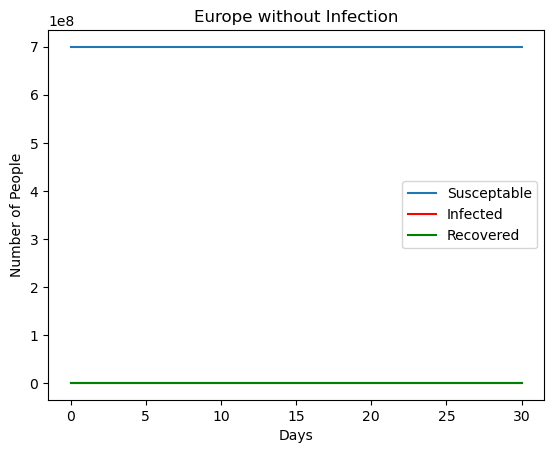

In [15]:
cure_humanity()
t, SIR_noI = combined_simulation(1, 1, 0.1, 0.1, 0.1, 30, "RK")

plot_global_values("Europe without Infection", t, SIR_noI)

Wie erwartet ergibt sich ein statischer Zustand des Modells.

Nun werden für bestimmte Parameter Grenzfälle überprüft, die sich aus den Differentialgleichungen ergeben. Zunächst werden die trivialen Fälle getestet, also:

- Keine Ausbreitungsdynamik: $\beta=0$, $\gamma=0$

- Keine Möglichkeit sich von der Krankheit zu erholen: $\beta=1$, $\gamma=0$

- Keine Neuansteckungen möglich: $\beta=0$, $\gamma=1$

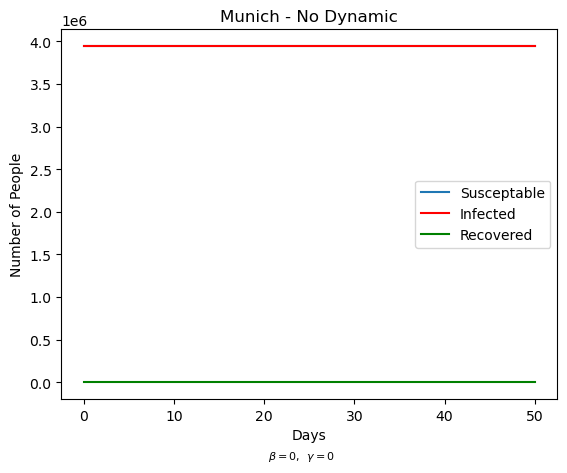

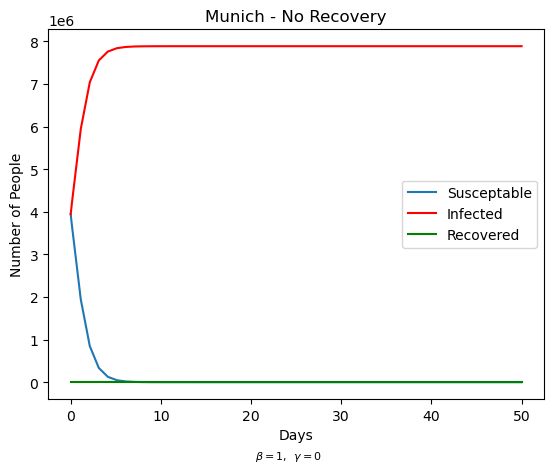

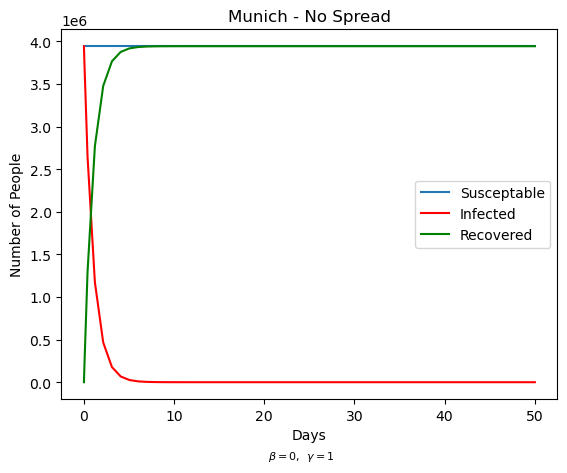

In [16]:
beta = 0
gamma = 0

cure_humanity()
cities['MUC'].infect_percent(0.5)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, 50)
plot_SIR('Munich - No Dynamic', sol.t, sol.y[0], sol.y[1], sol.y[2], values = {r'\beta': beta, r'\gamma': gamma})

beta = 1
gamma = 0

cure_humanity()
cities['MUC'].infect_percent(0.5)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, 50)
plot_SIR('Munich - No Recovery', sol.t, sol.y[0], sol.y[1], sol.y[2], values = {r'\beta': beta, r'\gamma': gamma})

beta = 0
gamma = 1

cure_humanity()
cities['MUC'].infect_percent(0.5)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, 50)
plot_SIR('Munich - No Spread', sol.t, sol.y[0], sol.y[1], sol.y[2], values = {r'\beta': beta, r'\gamma': gamma})

Nun wird ein nicht-trivialer Grenzfall betrachtet:


Für eine geringe initale Infektionszahl ergibt sich die Näherung $S\approx N$ und die Gleichung für die Infizierten vereinfacht sich zu:

$\frac{\mathrm{d} I}{\mathrm{d} t}\approx \beta I-\gamma I=(\beta-\gamma)I$

Definiert man nun $R_0=\frac{\beta}{\gamma}$ so erkennt man direkt den Grenzfall $R_0=1$, dessen Umgebung nun näher untersucht wird.

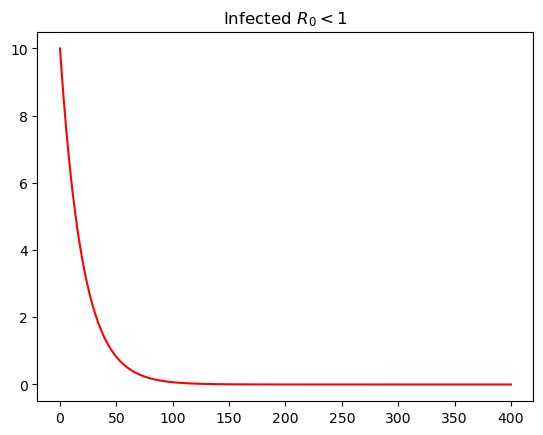

In [17]:
infected = 10
days = 400

beta = 0.45
gamma = 0.5

cure_humanity()
cities['MUC'].infect(infected)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, days)
plt.close()
plt.plot(sol.t, sol.y[1], color = 'r')
plt.title(r'Infected $R_0<1$')
plt.show()

Für $R_0<1$ ergibt sich eine Initiale Änderungsrate von $\frac{\mathrm{d} I}{\mathrm{d} t}<0$, wodurch die Krankheit von Beginn an ausstirbt.

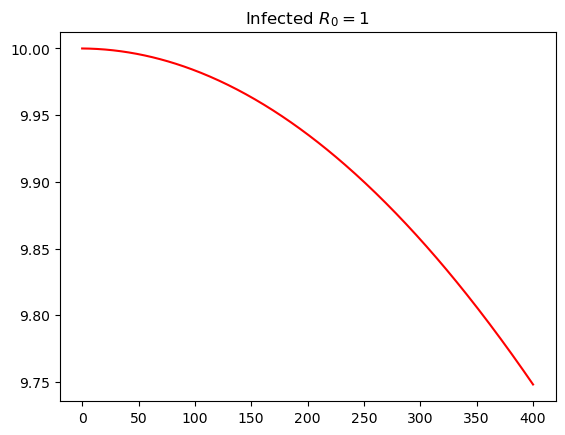

In [18]:
beta = 0.5
gamma = 0.5

cure_humanity()
cities['MUC'].infect(infected)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, days)
plt.close()
plt.plot(sol.t, sol.y[1], color = 'r')
plt.title(r'Infected $R_0=1$')
plt.show()

Für $R_0=1$ ergibt sich eine Initiale Änderungsrate von $\frac{\mathrm{d} I}{\mathrm{d} t}=0$, wodurch die die Zahl der Infizierten zunächst konstant bleibt. Da mit der Zeit aber die Zahl der für die Krankheit anfälligen Personen abnimmt, verliert die oben gemachte Näherung ihre Gültigkeit und die Krankheit stirbt langsam aus. Wie in der Grafik jedoch zu sehen ist, nimmt die Infektionszahl für eine niedrige initiale Zahl an Infizierten nur sehr langsam ab.

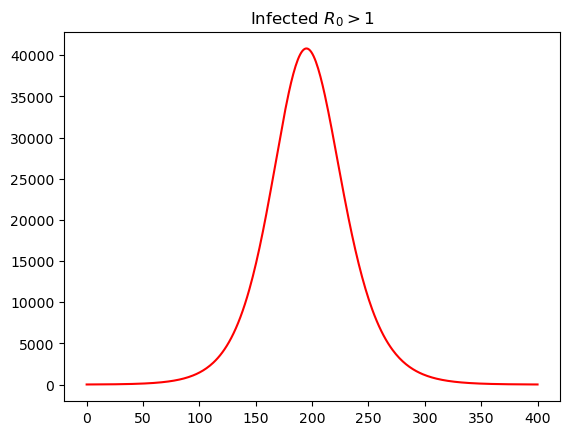

In [19]:
beta = 0.5
gamma = 0.45

cure_humanity()
cities['MUC'].infect(infected)
sol = calculate_SIR_ivp(cities['MUC'], beta, gamma, days)
plt.close()
plt.plot(sol.t, sol.y[1], color = 'r')
plt.title(r'Infected $R_0>1$')
plt.show()

Für $R_0>1$ ergibt sich eine Initiale Änderungsrate von $\frac{\mathrm{d} I}{\mathrm{d} t}>0$, wodurch sich die Krankheit von Tag 1 an gut ausbreitet, bis auch hier die Näherung fällt und die Kranheit ausstirbt.

## 4.2 Vegleich der Algorithmen in kombinierter Simulation

Anschließend wird eine Krankheit mit den Parametern $\beta=0.7$, $\gamma=0.07$ und $D=0.01$ untersucht, bei der 1000 Personen in Frankfurt infiziert werden. Anschließend werden 50 Zeitschritte für alle drei Lösungsverfahren untersucht und die Dynamiken von Frankfurt und Rom geplottet.

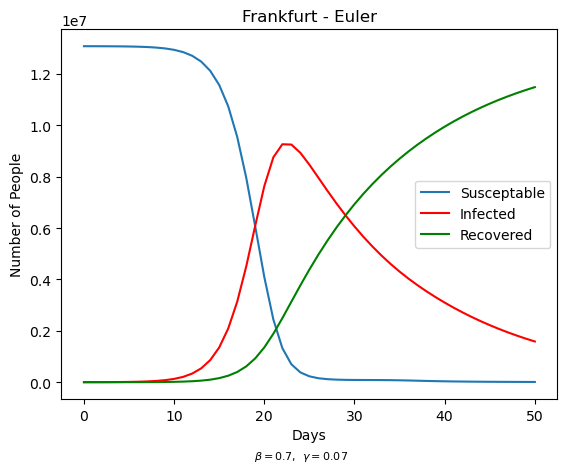

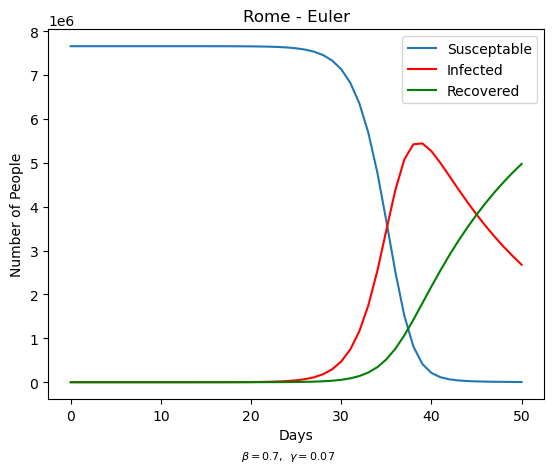

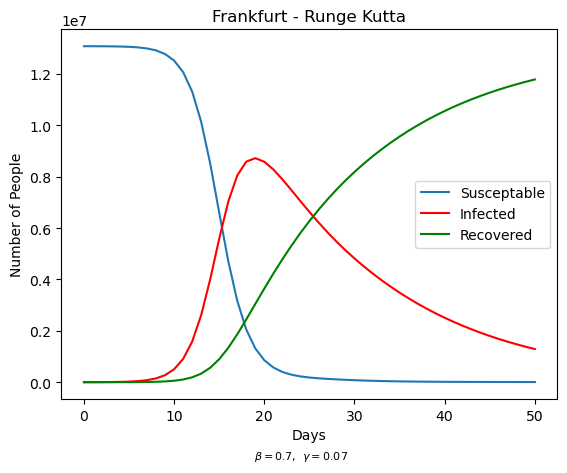

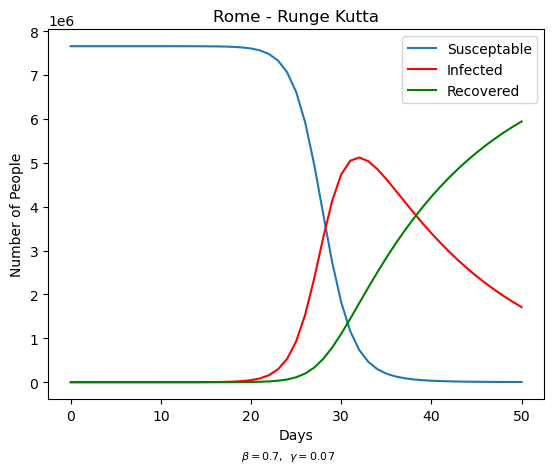

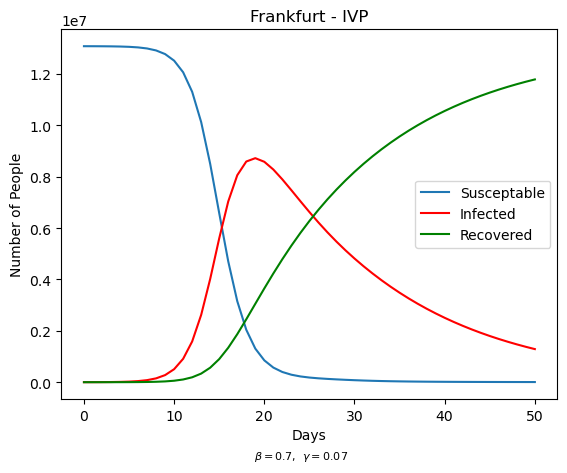

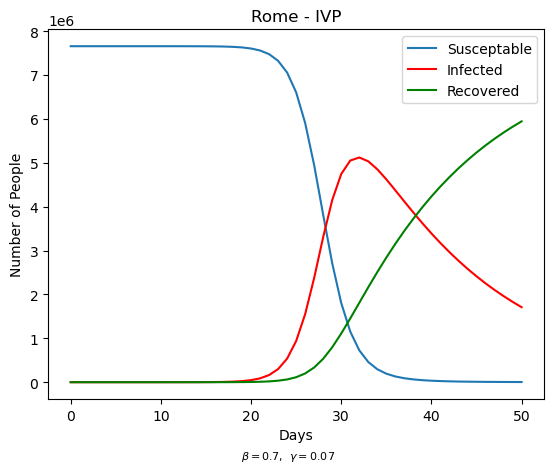

In [20]:
city = 'FCO' # Rome
beta = 0.7
gamma = 0.07
D = 0.01

cure_humanity()
cities['FRA'].infect(1000)
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "euler")
s, i, r = zip(*SIR_values['FRA'])
plot_SIR("Frankfurt - Euler", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})
s, i, r = zip(*SIR_values[city])
plot_SIR("Rome - Euler", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})

cure_humanity()
cities['FRA'].infect(1000)
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "RK")
s, i, r = zip(*SIR_values['FRA'])
plot_SIR("Frankfurt - Runge Kutta", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})
s, i, r = zip(*SIR_values[city])
plot_SIR("Rome - Runge Kutta", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})

cure_humanity()
cities['FRA'].infect(1000)
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "ivp")
s, i, r = zip(*SIR_values['FRA'])
plot_SIR("Frankfurt - IVP", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})
s, i, r = zip(*SIR_values[city])
plot_SIR("Rome - IVP", t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})

Wie oben wird auch für die kombinierte Simulation ein gemeinsamer Plot erstellt um die Verfahren besser vergleichen zu können.

Euler took 2057.875633239746ms
Runge-Kutta took 2088.104486465454ms
Solve_IVP took 7880.980014801025ms


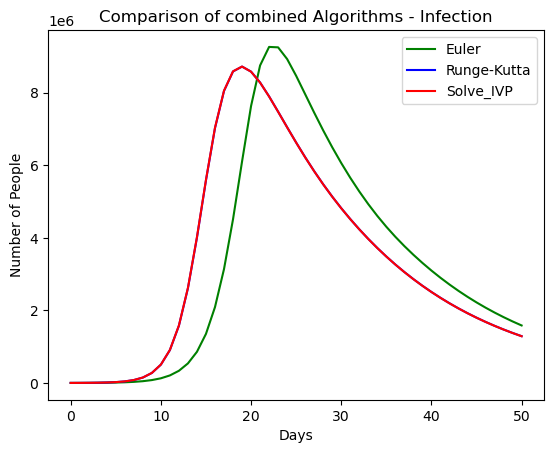

In [21]:
import time
# infect people - intial condition
test_city = cities['FRA']
beta = 0.7
gamma = 0.07
D = 0.01
days = 50

cure_humanity()
test_city.infect(1000)

plt.close()
# plot euler
ti = time.time()
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "euler")
print(f'Euler took {(time.time() - ti)*1000}ms')
s, i, r = zip(*SIR_values['FRA'])
plt.plot(t, i, c='green', label='Euler')

cure_humanity()
test_city.infect(1000)

#plot runge-kutta
ti = time.time()
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "RK")
print(f'Runge-Kutta took {(time.time() - ti)*1000}ms')
s, i, r = zip(*SIR_values['FRA'])
plt.plot(t, i, c='blue', label='Runge-Kutta')

cure_humanity()
test_city.infect(1000)

# plot ivp
ti = time.time()
t, SIR_values = combined_simulation(beta, gamma, D, D, D, 50, "ivp")
print(f'Solve_IVP took {(time.time() - ti)*1000}ms')
s, i, r = zip(*SIR_values['FRA'])
plt.plot(t, i, c='red', label='Solve_IVP')

plt.xlabel('Days')
plt.ylabel('Number of People')
plt.title('Comparison of combined Algorithms - Infection')
plt.legend()
plt.show()

Wie oben bereits zu sehen war, bestätigen sich das Runge-Kutta und das Solve_IVP Verfahren gegenseitig, da sie einen identischen Verlauf aufweisen. Das Euler-Verfahren ist hingegen zu ungenau und hat Probleme bei großen Änderungen der Steigung, weshalb die Kurve der Infizierten für dieses Verfahren auch eindeutig verzögert ansteigt. Da das Runge-Kutta etwa vier Mal schneller dasselbe Ergebnis lieferte wie die Solve_IVP Funktion, findet dieses Verfahren im weiteren Verlauf Anwendung.

## 4.3 Verhalten der SIR-Dynamik bei Variation der Parameter

Zunächst wird die Auswirkung des Parameters $\beta$ auf den Infektionsverlauf untersucht.

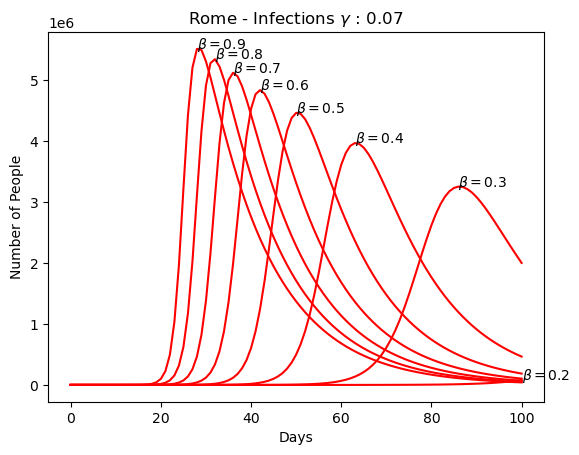

In [22]:
for b in np.arange(0.2,1,0.1): 
    cure_humanity()
    cities['DLM'].infect(1000)
    t, SIR_values = combined_simulation(b, gamma, D, D, D, 100, "RK")
    s, i, r = zip(*SIR_values[city])
    plot_SIR(fr'Rome - Infections $\gamma$ : {gamma}', t, i = i, values = {r'\beta': b}, plot=False)
plt.show()

Wie erwartet erkennt man, dass eine höhere Ansteckungsrate den Verlauf der Infektionen stark erhöht und beschleunigt. Je größer der Parameter, desto definierter der Peak und daraus resultierend die Belastung für das Gesundheitssystem, da sehr viele Personen auf einmal erkranken. Der gleiche Vergleich soll nun auch für die Erholungsrate gemacht werden.

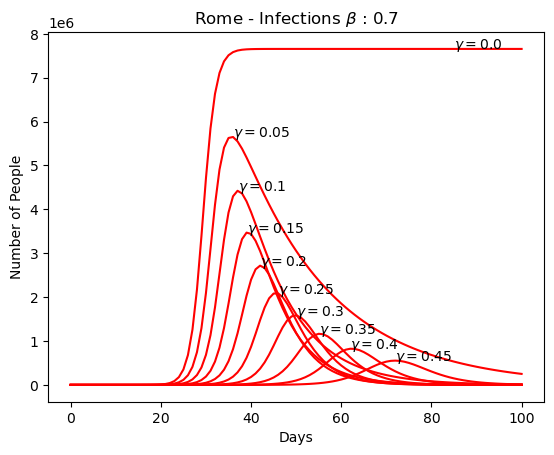

In [23]:
for g in np.arange(0,0.5,0.05): 
    cure_humanity()
    cities['DLM'].infect(1000)
    t, SIR_values = combined_simulation(beta, g, D, D, D, 100, "RK")
    s, i, r = zip(*SIR_values[city])
    plot_SIR(fr'Rome - Infections $\beta$ : {beta}', t, i = i, values = {r'\gamma': g}, plot=False)
plt.show()

Wie zu erkennen ist hat die Erholungsrate einen großen Einfluss auf die Form der Infektionskurve. Höhere Werte sorgen nicht nur für einen niedrigeren Peak, sondern lassen die Kurve nach diesem ebenso stärker abfallen. Generell ist hierbei anzumerken, dass $\gamma$ hierbei ein von der Krankheit vorgegebener Parameter ist, während $\beta$ durch entsprechende Maßnahmen verändert werden kann um beispielsweise die Kurve abzuflachen und damit die konzentrierte Belastung für das Gesundheitssystem möglichst klein zu halten.

## 4.4 Implementation der Animation

Um die Dynamik für den gesamten Kontinent zu visualisieren wird eine Animation erstellt. Auf einer Europakarte werden alle Flughäfen als Punkte dargestellt, während die Routen durch rote Striche angedeutet werden. Die Farbe der Punkte ist dabei abhängig vom derzeitigen Stand des Infektionsgeschehens, also welche der Gruppen gerade das Geschehen dominiert (Suceptible - blau, Infected - rot, Rovered - grün). Außerdem verändert sich die Größe der Punkte abhängig vom Anteil der infizierten Personen an der Gesamtbevölkerung. Die Routen werden nicht kontinuierlichangezeigt, sondern verändern ihre Sichtbarkeit abhängig von der Differenz der relativen Infektionszahlen der verbunden Städte. Je größer dieser Gradient, desto mehr infizierte übertragen die Krankheit und desto sichtbarer werden die Routen.

Demnach müssen für jeden Zeitschritt alle Städte und Routen abhängig vom derzeitigen Geschehen aktualisiert werden. Um nicht in jedem Schritt alle Objekte komplett neu plotten zu müssen, werden diese nur initalisiert und anschließend in jedem Zeitschritt neu eingefärbt bzw. ihre Transparenz oder Größe verändert. Dafür müssen sie in der Funktion 'initialize_plot' nicht nur geplottet, sondern auch in Listen abgespeichert werden, sodass sie später refernziert und verändert werden können.

In [8]:
connection_lines = {}
line_objects = []
city_markers = []
closed_markers = []

def initialize_plot (show_routes, add_closed = False, geodetic=True):
    line_objects.clear()
    city_markers.clear()
    closed_markers.clear()
    connection_lines.clear()
    # Create a new map with the PlateCarree projection.
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    # Create a mapping from airport IATA codes to latitudes and longitudes
    airport_IATA_to_lat_lon = {row[0] : {'lat': row[1], 'lon': row[2]} for row in airports[['IATA', 'latitude', 'longitude']].values}

    # create markers and lines
    for i, city in enumerate(cities):
        pos = airport_IATA_to_lat_lon[city]
        if geodetic:
            marker = ax.plot(pos['lon'], pos['lat'], 'o', transform=ccrs.Geodetic(), c='blue', markersize = 2.5)
            if add_closed:
                closed_marker = ax.plot(pos['lon'], pos['lat'], 'x', transform=ccrs.Geodetic(), c='red', markersize = 2.5,linewidth=0.05, alpha=0)
        else:
            marker = ax.plot(pos['lon'], pos['lat'], 'o', c='blue', markersize = 2.5)
            if add_closed:
                closed_marker = ax.plot(pos['lon'], pos['lat'], 'x', c='red', markersize = 2.5, linewidth=0.05, alpha=0)
        city_markers.append(marker[0])
        line_objects.append(marker[0])
        if add_closed:
            closed_markers.append(closed_marker[0])
            line_objects.append(closed_marker[0])
        
        if not show_routes:
            continue
        
        connection_lines[i] = []
        for j in range(i):
            if routes_matrix.iloc[i, j] != 0:
                source_pos = pos
                dest_pos = airport_IATA_to_lat_lon[routes_matrix.columns[j]]
                if geodetic:
                    line = ax.plot([source_pos['lon'], dest_pos['lon']],[source_pos['lat'], dest_pos['lat']],transform=ccrs.Geodetic(), c='r', alpha=0, markersize=.02)
                else:
                    line = ax.plot([source_pos['lon'], dest_pos['lon']],[source_pos['lat'], dest_pos['lat']], c='r', alpha=0, markersize=.02)
                connection_lines[i].append((j, line[0]))
                line_objects.append(line[0])
    
    
    global initialized
    initialized = True
    return ax

Nun werden wie oben beschrieben die Städte und optional auch die Routen aktualisiert. Bei den Routen wird der bereits verwendete diskrete Laplace-Operator verwendet um die Linienstärke zu definieren.

In [9]:
def plot_state(ax, SIR, day, show_routes=False):
    
    for i, city in enumerate(SIR):
        S, I, R = SIR[city][day]
        N = (S + I + R)
        infection_percent = I / N
        # update markers
        marker = city_markers[i]
        marker.set_color((I/N, R/N, S/N))
        marker.set_markersize(2.5 + 2 * infection_percent)

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Ij, Rj = SIR[list(SIR.keys())[j]][day]
            Nj = Sj + Ij+ Rj
            line.set(alpha = abs((N/Nj * Ij - I)) / (N) * 0.1)

In [10]:
initialized = False

def create_infection_progress_animation(values, plot_state_func, days, title, show_routes=False, show_closed=False):
    fig = plt.figure(figsize=(16, 9))
    ax = initialize_plot(show_routes, show_closed)
    ax.set_title(f'{title} - Day 0')
    plt.tight_layout()
    
    def update(frame):
        clear_output(wait=True)
        print(frame)
        ax.set_title(f'{title} - Day {frame}')
        plot_state_func(ax, values, frame, show_routes=show_routes)
        return line_objects

    animation = FuncAnimation(fig, update, frames=days, interval=200, blit=True)
    
    plt.close()

    clear_output(wait=True)
    print('done - saving...')
    
    # save animation
    animation.save(f"figures/{title}.gif", fps=2.5, dpi=200)

    clear_output(wait=True)
    print('saved')
   
    display(Image(url=f'figures/{title}.gif'))

## 4.5 Simulation verschiedener Krankheiten

Um ein Gefühl für unsere implementierte Simulation zu bekommen, testen wir nun diese mit drei verschiedenen Krankheiten und dessen approximativen $\beta$ und $\gamma$ Werten. Nutzen wir die Beziehung $R_0 = \frac{\beta}{\gamma}$, ist es uns möglich einen ungefähren Wert für Beta und Gamma abzuschätzen. Der Faktor $1 / \gamma$ ist dabei die durchschnittliche Dauer der infektiösen Periode.

Es ist natürlich anzumerken, dass es sich bei der Simulation verschiedenster Krankheiten um abgeschätzte Werte sowie einen stark simplifizierten Ausbreitungsverlauf handelt. In der Realität spielen signifikant mehr Faktoren eine Rolle, als wir sie hier in einem einfachen Modell berücksichtigen könnten.

### 4.5.1 Influenza

Als erste Krankheit verwenden wir Werte der Krankheit Influenza. Hier stellt das Robert Koch Institut eine mittlere Dauer der Ansteckungsgefahr von Tagen 5-7 fest. Zusätzlich wird der Influenza eine Basisreproduktionszahl von ca. 1,6 zugeordnet. Das ergibt $\gamma = 0,167$ und $\beta = 1,6 \cdot 0,167 = 0,267$.

Quellen:

- Infektiöse Periode: https://www.rki.de/SharedDocs/FAQ/Influenza/FAQ_Liste.html

- Basisreproduktionszahl: https://de.wikipedia.org/wiki/Basisreproduktionszahl

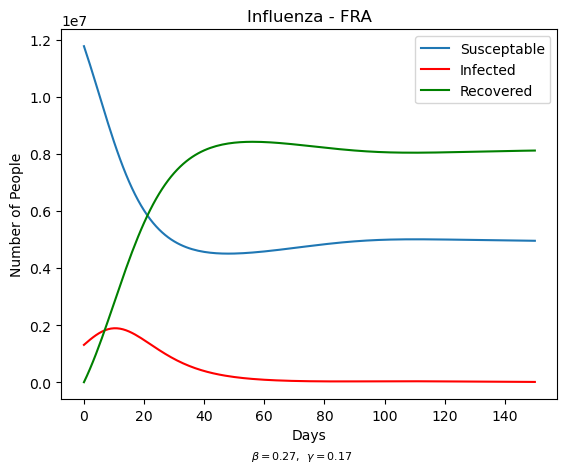

Gesamtzahl der Infizierten: 8127302.0


In [27]:
beta = 0.267
gamma = 0.167
days = 1 * 150
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
S, I, R = zip(*SIR_values[city])
plot_SIR('Influenza - FRA', t, S, I, R, values = {r'\beta': beta, r'\gamma': gamma})

print(f"Gesamtzahl der Infizierten: {round(R[-1]+I[-1],0)}")

Nun betrachten wir noch die räumliche Ausbreitung der Influenza-Welle über Europa mithilfe einer Animation.

In [28]:
beta = 0.267
gamma = 0.167
days = 1 * 150
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
create_infection_progress_animation(SIR_values, plot_state, days, "Influenza - FRA", True, False)

saved


Die von uns durchgeführte Simulation kann als - für Influenza typische - Grippewelle betrachtet werden. Wir starten mit einer Infektionsrate von 10% in Frankfurt. Im Laufe der Zeit ist es der Krankheit möglich seine Infektionszahlen zu verdoppeln, bis die Ansteckungsrate an Zulauf verliert. Insgesamt wurden innerhalb von ca. 150 Tagen 62,8% der Stadt infiziert. Die ersten 50 Tage waren hierbei jedoch die intensivsten, da hier die Infektionszahlen ihr Maximum erreichen. Die Kurve der infizierten Personen zeigt einen stärkeren Peak, was auf geringe schützende Maßnahmen schließen lässt, wie es in unserem Modell auch der Fall ist. Verglichen mit den Krankheiten Keuchhusten und Masern, die im Folgenden noch betrachtet werden, hat Influenza es nicht geschafft die Gesamtheit der Stadt zu infizieren und zeichnet sich ebenso durch eine deutlich schwächere Infektionsrate aus. Anders als für die anderen Krankheiten ist ein solcher Verlauf von Influenza jedoch grundsätzlich als realistisch zu betrachten, da wir in der Realität saisonale Grippewellen beobachten können, die einen ähnlichen Verlauf zeigen. Ebenso wurden für Keuchhusten und Masern im 20. Jahrhundert Impfstoffe entwickelt, die in der Lage waren die Krankheiten an den Rand der Ausrottung zu drängen.

### 3.4.2 Keuchhusten

Für Keuchhusten liegt die Basisreproduktionszahl bei ca. 9,75 und kann bis zu 3 Wochen ansteckend wirken. Wir erhalten die Werte $\gamma = 0,048$ und $\beta = 0,464$

Quellen:

- Ansteckungsdauer: https://www.rki.de/DE/Content/Infekt/EpidBull/Merkblaetter/Ratgeber_Pertussis.html

- Basisreproduktionszahl: https://de.wikipedia.org/wiki/Basisreproduktionszahl

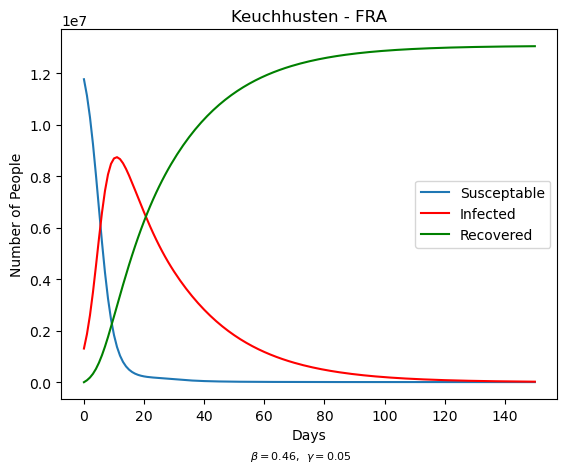

Gesamtzahl der Infizierten: 13079034.0


In [29]:
beta = 0.464
gamma = 0.048
days = 1 * 150
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
S, I, R = zip(*SIR_values[city])
plot_SIR('Keuchhusten - FRA', t, S, I, R, values = {r'\beta': beta, r'\gamma': gamma})

print(f"Gesamtzahl der Infizierten: {round(R[-1]+I[-1],0)}")

In [30]:
beta = 0.46
gamma = 0.05
days = 1 * 150
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
create_infection_progress_animation(SIR_values, plot_state, days, "Keuchhusten - FRA", True, False)

saved


Geschichtlich gesehen ereigneten sich einige große Keuchhustenepidemien im 19. Jahrhundert. Auch wenn die Krankheit besonders gefährlich für Kleinkinder ist, können erwachsene Menschen ebenso daran erkranken und den Erreger verbreiten. Die Krankheit fällt durch seine hohe Ansteckungsrate und die Ähnlichkeit der Symptome mit Krankheiten wie Grippe oder Erkältung auf, was es bei älteren Erkrankten schwer machen kann die Krankheit zu erkennen. Der Verlauf von Keuchhusten zeigt im Vergleich Ähnlichkeiten mit dem der Masern, jedoch hat der Keuchhustein eine geringere Infektionsrate und ebenso eine deutlich geringere Genesenrate. Der lang anhaltende Krankheitsverlauf führt dazu, dass trotz hoher Basisreproduktionszahl, keine explosionsartige Ausbreitung der Krankheit möglich ist. Der Krankheit ist es in unserer Simulation gelungen nach ca. 150 Tagen alle Menschen Frankfurts zu infizieren. 

### 4.3.3 Masern

Für Masern liegt die durchschnittliche Dauer der Ansteckungsgefahr laut Bundeszentrale für gesundheitliche Aufklärung bei 7-9 Tagen und die Basisreproduktionszahl bei ca. 14. Dementsprechend sind die Werte für unsere Simulation $\gamma = 0,125$ und $\beta = 1,75$

Quellen:

- Infektiöse Periode: https://www.infektionsschutz.de/erregersteckbriefe/masern/

- Basisreproduktionszahl: https://de.wikipedia.org/wiki/Basisreproduktionszahl

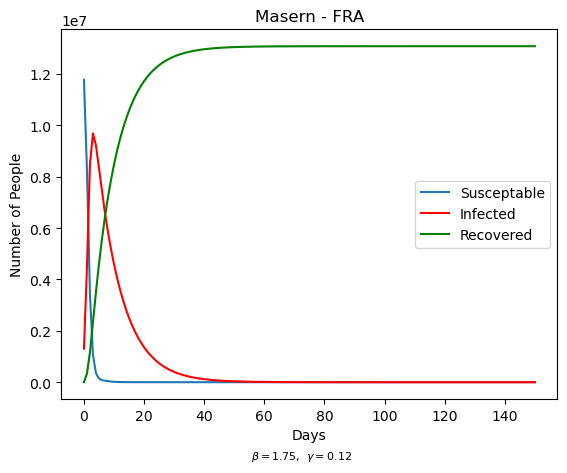

Gesamtzahl der Infizierten: 13083078.0


In [31]:
beta = 1.75
gamma = 0.125
days = 1 * 150
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
S, I, R = zip(*SIR_values[city])
plot_SIR('Masern - FRA', t, S, I, R, values = {r'\beta': beta, r'\gamma': gamma})

print(f"Gesamtzahl der Infizierten: {round(R[-1]+I[-1],0)}")

In [32]:
beta = 1.75
gamma = 0.12
days = 1 * 80
city = 'FRA'

cure_humanity()
cities[city].infect_percent(0.1)
t, SIR_values = combined_simulation(beta, gamma, 0.01, 0.01, 0.01, days, 'RK')
create_infection_progress_animation(SIR_values, plot_state, days, "Masern - FRA", True, False)

saved


Betrachtet man die erfassten Masernkrankheiten vor dem Impfstoff in 1963, lässt sich eine ähnliche Struktur von Infektions- und Genesenrate feststellen. Ein Masernausbruch erfolgt schnell mit hohen Erkrankungszahlen, klingt aber auch ebenso schnell wieder ab. In der Realität zählen die Masern mittlerweile aufgrund der lebenslänglichen Immunität nach einer Maserninfektion sowie den Impfstoffen in 1963 & 1996 zu den ausgerotteten Krankheiten. Im Vergleich zu den anderen betrachteten Krankheiten fallen die Masern aufgrund ihres extrem hohen Infektionswertes von $\beta = 1.75$ auf. Ebenso ist es der Krankheit gelungen, die Gesamtheit Frankfurts innerhalb von 50 Tagen zu infizieren. Deutlich schneller als es bei Keuchhusten der Fall war. In der Animation und dem Graphen ist schön die explosionsartige Ausbreitung der Krankheit zu erkennen, die typisch für einen Masernausbruch ist. 

# 5 Erweitertung des Modells



## 5.1 Erläuterung der Modifikationen 

Betrachten wir einen realistischen Ablauf einer Epidemie, so fällt schnell auf, dass die Simulation mittels SIR-Modell nur eine sehr vereinfachte Darstellung liefert. Da es unser Ziel ist den Verlauf einer Epidemie so genau wie möglich zu bescheiben, liegt es nahe das Modell um einige Faktoren zu erweitern. 

Die Aufteilung der Bevölkerung in 3 Gruppen ist nicht ausreichend, da in dem Modell nicht zwischen Verstorbenen und Genesenen Menschen unterschieden wird. Außerdem fehlt die Möglichkeit, dass sich bereits genesene Person erneut mit der Krankheit anstecken können. Dementsprechend haben wir im erweiterten Modell eine Gruppe D für Tote (Dead), sowie einen möglichen Übergang zwischen S und R hinzugefügt.

Weiterhin bleibt $\gamma$ die Rate mit der sich infizierte Menschen von der Krankheit 'erholen' (Inverse der Krankheitsdauer). Allerdings gibt es nun einen weiteren Parameter $\mu$ der die Wahrscheinlichkeit aufgrund der Krankheit zu sterben angibt. In Verbindung mit $\gamma$ kann so der Übergang von I nach D oder R modelliert werden. Um eine mögliche Wiederansteckung mit der Krankheit zu implementieren, nutzen wir den Faktor $\lambda$, der sich aus dem Inversen der erwarteten Immunitätszeit bildet.

Anschließend erweitern wir das Modell noch um zwei weitere Gruppen. Einerseits mit der Gruppe Z von Menschen innerhalb einer Inkubationszeit und andererseits mit der Gruppe A, welche asymptomatische Personen umfasst. Der Faktor $\kappa$ gibt den Übergang von Infektion zu Ausbruch der Krankheit an und bildet sich aus dem Inversen der durchschnittlichen Inkubationsdauer. Außerdem gibt $\sigma$ die Wahrscheinlichkeit an, dass bei einer infizierten Person die Krankheit tatsächlich ausbricht und beschreibt damit den Übergang von Z zu A und I. Zuletzt beschreibt der Parameter $\upsilon$ den Übergang von A nach R, der sich ähnlich wie $\gamma$ aus der inversen Krankheitsdauer berechnen lässt. Der Parameter ist unabhängig von $\gamma$, da davon ausgegangen wird, dass sich asymptomatische Personen auch schneller erholen.

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S (I + A)}{N} + \lambda R,\tag{8}\\
    &\frac{\mathrm{d} Z}{\mathrm{d} t} = \beta \frac{S (I + A)}{N} - \kappa Z,\tag{9}\\
    &\frac{\mathrm{d} A}{\mathrm{d} t} = (1-\sigma)\kappa Z - \upsilon A,\tag{10} \\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \sigma \kappa Z - \gamma I,\tag{11}\\
    &\frac{\mathrm{d} D}{\mathrm{d} t} = \mu \gamma I,\tag{12}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = (1-\mu)\gamma I + \upsilon A\tag{13} - \lambda R
\end{align}

## 5.2 Erweiterung des Grundkonstruktes

Zunächst wird die class City erweitert

In [11]:
# data class to hold infection values
class ExpCity:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.reset_city()
    
    def infect_percent(self, percent):
        self.Z += self.S * percent
        self.S = self.S - self.S * percent
        
    def infect(self, newly_infected, asymptomatic=0):
        self.Z += newly_infected
        self.A += asymptomatic
        self.S = self.S - newly_infected - asymptomatic

    def handle_restrictions(self, close_percent, open_percent):
        if not self.airport_closed and self.I / self.population > close_percent:
            self.airport_closed = True
        
        if self.airport_closed and self.I / self.population < open_percent:
            self.airport_closed = False
       
    def reset_city(self):
        self.airport_closed = False
        self.S = self.population
        self.Z = 0
        self.I = 0
        self.A = 0
        self.D = 0
        self.R = 0

und ein neues cities Dictionary erstellt.

In [12]:
# create a new dict with iata to cities
cities_exp = {}
for airport in (airports[['population', 'IATA']]).values:
    cities_exp[airport[1]] = (ExpCity(airport[0], airport[1]))

def cure_humanity_exp():
    for c in cities_exp.values():
        c.reset_city()

# 6 Tote, Inkubationszeit und Wiederansteckung

Zunächst wird die asymptotische Gruppe weggelassen, da diese erst in Verbindung mit Maßnahmen interessant wird. Deshalb wird die Funktion, welche einen Zeitschritt der SIR-Dynamik beschreibt nun zunächst mit den neuen Gruppen Z und D ergänzt. Demnach wird aus der SIR-Dynamik die SZIDR-Dynamik.

In [13]:
def step_SZIDR(c : ExpCity, beta, gamma, _lambda, kappa, mu, dt):
    # SIR + incubation + recovered -> susceptable

    b_over_n = beta / c.population
    
    def derivatives(S, Z, I, R):
        dS_dt = -b_over_n * S * I + _lambda * R
        dZ_dt = b_over_n * S * I - kappa * Z
        dI_dt = - gamma * I + kappa * Z
        dD_dt = mu * gamma * I
        dR_dt = (1-mu) * gamma * I - _lambda * R

        return dS_dt, dZ_dt, dI_dt, dD_dt, dR_dt
    
    S = c.S
    Z = c.Z
    I = c.I
    D = c.D
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_Z, k1_I, k1_D, k1_R = derivatives(S, Z, I, R) * dt
    k2_S, k2_Z, k2_I, k2_D, k2_R = derivatives(S + 0.5 * k1_S, Z + 0.5 * k1_Z, I + 0.5 * k1_I, R + 0.5 * k1_R) * dt
    k3_S, k3_Z, k3_I, k3_D, k3_R = derivatives(S + 0.5 * k2_S, Z + 0.5 * k2_Z, I + 0.5 * k2_I, R + 0.5 * k2_R) * dt
    k4_S, k4_Z, k4_I, k4_D, k4_R = derivatives(S + k3_S, Z + k3_Z, I + k3_I, R + k3_R) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.Z = Z + (1/6) * (k1_Z + 2*k2_Z + 2*k3_Z + k4_Z)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.D = D + (1/6) * (k1_D + 2*k2_D + 2*k3_D + k4_D)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

Die neue Dynamik kann nun für eine Stadt geplottet werden. Es muss sichergestellt werden, dass die erweiterte Dynamik weiterhin ein sinnvolles Verhalten aufweist. Deshalb wird für diesen Testlauf auch die Gesamtbevölkerung geplottet, die konstant bleiben sollte. Die neuen Parameter werden zunächst versucht sinnvoll zu approximieren. Nach 90 Tagen ist nun im Schnitt eine Wiederansteckung möglich ($\lambda=\frac{1}{90}$), während die Inkubationszeit durchschnittlich 4 Tage beträgt ($\kappa=\frac{1}{4}$). Die Todesrate wird auf ein Prozent gesetzt.

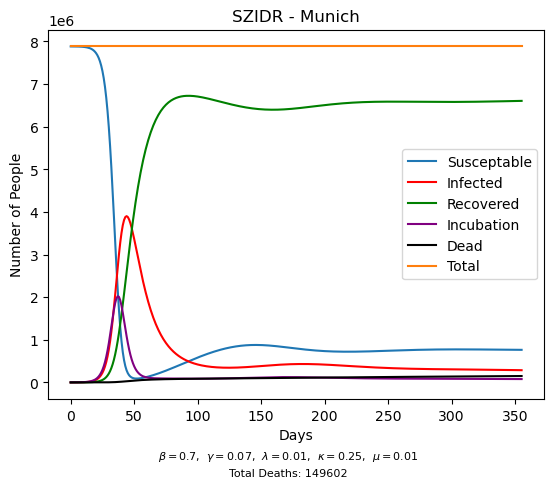

In [36]:
# infect people - intial condition
test_city = cities_exp['MUC']
test_city.reset_city()
test_city.infect(1000)

beta = 0.7
gamma = 0.07
lambda_0 = 1/90
kappa = 1/4
mu = .01

t,s,z,i,d,r = ([] for i in range(6))
total_i= 0
total = []
for n in range(356 * 1):
    t.append(n)
    s.append(test_city.S)
    z.append(test_city.Z)
    i.append(test_city.I)
    d.append(test_city.D)
    r.append(test_city.R)
    total.append(test_city.S + test_city.Z + test_city.I + test_city.D + test_city.R)

    total_i += kappa * test_city.Z

    test_city = step_SZIDR(test_city, beta, gamma, lambda_0 * (0.5 ** (total_i / test_city.population)), kappa, mu, 1)


plot_SIR(f"SZIDR - Munich", t, s, i, r, z, d, total, values={r'\beta': beta, r'\gamma': gamma, r'\lambda': lambda_0, r'\kappa': kappa, r'\mu': mu})

Für eine europaweite Simulation müssen nun auch das Reisemodell und die kombinierte Simulation um die neuen Gruppen erweitert werden.

In [14]:
def calculate_travel_exp (ci : ExpCity, ds, dz, di, dr):
    # Calculate a travel step for given city
    sumS = 0
    sumZ = 0
    sumI = 0
    sumR = 0

    deg_i = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities_exp[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumZ += n * cj.Z - ci.Z
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R 
        
        deg_i += 1
    
    return (ds * sumS / deg_i, dz * sumZ / deg_i, di * sumI / deg_i, dr * sumR / deg_i)

In [15]:
def combined_simulation_exp (beta, gamma, lambda_0, kappa, mu, ds, dz, di, dr, days):
    
    SZIDR_values = {}
    num_cases = {}
    for c in cities_exp:
        SZIDR_values[c] = []
        num_cases[c] = cities_exp[c].Z
    t = [0]

    temp_values = {}

    # add initial state
    for c in cities_exp.values():
        SZIDR_values[c.IATA].append((c.S, c.Z, c.I, c.D, c.R))
        
    for i in range(days):
        # sir dynamic
        for c in cities_exp.values():
            c = step_SZIDR(c, beta, gamma,lambda_0 * (0.5 ** (num_cases[c.IATA] / c.population)), kappa, mu, 1)
        # travel diffusion - don't apply it yet
        for c in cities_exp.values():    
            diff_S, diff_Z, diff_I, diff_R = calculate_travel_exp (c, ds, dz, di, dr)
            temp_values[c.IATA]=(c.S + diff_S,c.Z + diff_Z, c.I + diff_I, c.D, c.R + diff_R)
        
        # apply the values
        for c in cities_exp.values():
            (c.S, c.Z, c.I, c.D, c.R) = temp_values[c.IATA]
            SZIDR_values[c.IATA].append(temp_values[c.IATA])
            
        num_cases[c.IATA] += kappa * test_city.Z 
        t.append(i+1)    
    return t, SZIDR_values

Auch die Funktion, welche einen Schritt der Animation ausführt muss erweitert werden.

In [16]:
def plot_state_exp(ax, SZIDR, day, show_routes=False):
    
    for i, city in enumerate(SZIDR):
        S, Z, I, D, R = SZIDR[city][day]
        N = (S + Z +I + D + R)
        infection_percent = I / N
        # update markers
        marker = city_markers[i]
        color = (I/N, R/N, S/N)
        brightness = 1 - D/N
    
        marker.set(color = tuple([c* brightness for c in color]))
        marker.set_markersize(2.5 + 2 * (infection_percent + D/N))

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Zj, Ij, Dj, Rj = SZIDR[list(SZIDR.keys())[j]][day]
            Nj = Sj + Zj + Ij+ Dj + Rj
            diff_percent = abs((N/Nj * Ij - I)) / (N)
            #line.set(color = (min(1, diff_percent * 10), 0, 0))
            line.set(alpha = diff_percent * 0.05)
        
            

Nun kann die Simulation durchgeführt werden, um zu gewährleisten, dass das Modell immernoch funktioniert.

In [40]:
cure_humanity_exp()
city = cities_exp['LIS']
city.infect_percent(.1)
days = 100
t, SZIDR_values = combined_simulation_exp(0.8, 0.07, 1/90, 1/5, .02, 0.01, 0.01, 0.01, 0.01, days)

create_infection_progress_animation(SZIDR_values, plot_state_exp, days, "SZIDR", False)

saved


### 6.1 Tests am SZIDR-Modell

Zunächst wird die Anzahl der Toten für unterschiedliche Ansteckungsparameter $\beta$ untersucht.

In [17]:
def total_deaths(SZIDR_values):
    total = 0
    for c in cities_exp:
        S, Z, I, D, R = zip(*SZIDR_values[c])
        total += D[-1]
    return total

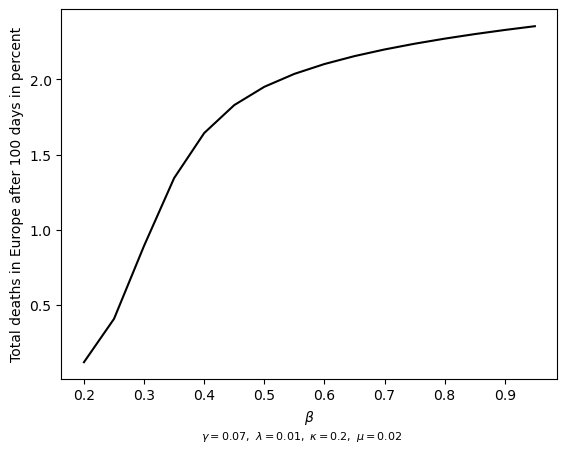

In [42]:
deaths = []
betas = []
gamma = 0.07
lambda_0 = 1/90
kappa = 1/5
mu = 0.02

days = 100
total_population = sum(c.population for c in cities_exp.values())

r = np.arange(.2, 1, 0.05)
for b in r:
    cure_humanity_exp()
    city = cities_exp['BRE']
    city.infect_percent(.1)

    t, SZIDR_values = combined_simulation_exp(b, gamma, lambda_0, kappa, mu, 0.01, 0.01, 0.01, 0.01, days)
    deaths.append(total_deaths(SZIDR_values) / total_population * 100)
    betas.append(b)

plt.plot(betas, deaths, c='black')
plt.xlabel(r'$\beta$')
plt.ylabel(f'Total deaths in Europe after {days} days in percent')
plt.figtext(.5,-.015, fr'$\gamma = {gamma},\ \lambda = {round(lambda_0,2)},\ \kappa = {round(kappa,2)},\ \mu = {round(mu,2)}$', fontsize=8, ha='center')
plt.show()


Hier ist eine eindeutige Korrelation zwischen Ansteckungsrate und Anzahl der Toten zu erkennen. Für kleinere $\beta$ nimmt die Anzahl der Toten nahezu linear zu, bis die Kurve bei etwa 0,35 beginnt abzuflachen. Bereits bei etwa 0,5 erreichen die Toten 2 $\%$ der Gesamtbevölkerung. Die Todesrate $\mu=0.02$ würde erwarten lassen, dass sich die Kurve asymptotisch an diesen Wert annhähert. Da in diesem Modell aber bereits die Wiederansteckungen integriert wurden, kann die Anzahl der Toten über diesen Wert ansteigen.

Nun wird auch die Lethalitätsrate untersucht.

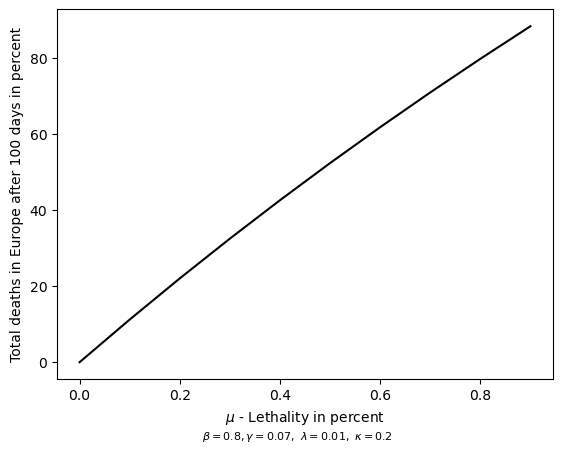

In [43]:
deaths = []
mus = []
beta = 0.8
gamma = 0.07
lambda_0 = 1/90
kappa = 1/5
days = 100
total_population = sum(c.population for c in cities_exp.values())

r = np.arange(0, 1, 0.1)
for mu in r:
    cure_humanity_exp()
    city = cities_exp['BRE']
    city.infect_percent(.1)

    t, SZIDR_values = combined_simulation_exp(beta, gamma, lambda_0, kappa, mu, 0.01, 0.01, 0.01, 0.01, days)
    deaths.append(total_deaths(SZIDR_values) / total_population * 100)
    mus.append(mu)

plt.plot(mus, deaths, c='black')
plt.xlabel(r'$\mu$ - Lethality in percent')
plt.ylabel(f'Total deaths in Europe after {days} days in percent')
plt.figtext(.5,-.015, fr'$\beta = {beta}, \gamma = {gamma},\ \lambda = {round(lambda_0,2)},\ \kappa = {round(kappa,2)}$', fontsize=8, ha='center')
plt.show()


In [44]:
cure_humanity_exp()
city = cities_exp['BRE']
city.infect_percent(.1)

t, SZIDR_values = combined_simulation_exp(0.8, gamma, lambda_0, kappa, 1, 0.01, 0.01, 0.01, 0.01, days)
create_infection_progress_animation(SZIDR_values, plot_state_exp, days, "SZIDR", False)

saved


Je höher die Wahrscheinlichkeit an einer Krankheit zu sterben, desto mehr Menschen sterben an dieser. Diese Erkenntnis sollte niemanden überraschen. Allerdings zeigt diese Untersuchung, dass die Parameter in diesem Modell nicht so einfach unabhängig voneinander betrachtet werden können. Ist eine Krankheit nämlich besonders tödlich, so verkürzt sich normalerweise auch die Dauer der Krankheit. Verändert man ausschließlich das $\mu$, so bleibt der Verlauf der Infektionskurve nahzu gleich, da es dem Modell egal ist, ob die Personen sterben, oder sich von der Krankheit erholen. Einzig der Übergang von R zu S würde dadruch beeinflusst werden. Da der zugehörige Parameter $\lambda$ aber sehr klein gewählt wurde, ist der Effekt sehr gering. Demnach müsste für ein realistischeres Szenario auch das $\gamma$ entsprechend verändert werden.

In der Realität ist anzunehmen, dass sich besonders tödliche Viren nicht so gut ausrbeiten, da sie die Infektionsdauer und Exposition des Infizierten gleichermaßen stark senken. Macht eine Krankheit stark krank, so werden Infizierte ans Bett gefesselt, die Ansteckungsgefahr frühzeitig erkannt und Gegenmaßnahmen getroffen. Diese werden in dieser Grafik nicht berücksichtigt, weshalb der Zusammenhang nahezu linear ist.

# 7. Asymptomatische Verläufe und Maßnahmen

Während der Corona Pandemie wurden einige Maßnahmen ergriffen, um die Ausbreitung des Virus zu verhindern. Besonders präsent waren dabei die Reiseeinschränkungen im öffentlichen Verkehrssektor. In unserem Modell wird diese Maßnahme durch Flughafenschließungen realisiert. Diese treten in Kraft, sobald ein festgelegter Prozentsatz der Bevölkerung (symptomatisch) infiziert ist und werden bei einem anderen Prozentsatz wieder gelockert. In unserem Modell interagiert die Maßnahme mit den eingeführten asymptomatischen Infizierten, da diese nicht zur Schließung der Flughäfen beitragen, aber dennoch in der Lage sind andere Menschen anzustecken.

## 7.1 Implementation

Dafür wird wieder zuerst die step Funktion angepasst und um die neuen Gruppen und Parameter ergänzt.

In [18]:
def step_SZAIDR(c : ExpCity, beta, gamma, _lambda, kappa, mu, sigma, upsilon, dt):
    # SIR + incubation + recovered -> susceptable + asymptomatic

    b_over_n = beta / c.population
    
    def derivatives(S, Z, A, I, R):
        dS_dt = -b_over_n * S * (I + A) + _lambda * R
        dZ_dt = b_over_n * S * (I + A) - kappa * Z
        dA_dt = (1 - sigma) * kappa * Z - upsilon * A
        dI_dt = kappa * Z * sigma - gamma * I
        dD_dt = mu * gamma * I
        dR_dt = (1-mu) * gamma * I + upsilon * A - _lambda * R

        return dS_dt, dZ_dt, dA_dt, dI_dt, dD_dt, dR_dt
    
    S = c.S
    Z = c.Z
    A = c.A
    I = c.I
    D = c.D
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_Z, k1_A, k1_I, k1_D, k1_R = derivatives(S, Z, A, I, R) * dt
    k2_S, k2_Z, k2_A, k2_I, k2_D, k2_R = derivatives(S + 0.5 * k1_S, Z + 0.5 * k1_Z, A + 0.5 * k1_A, I + 0.5 * k1_I, R + 0.5 * k1_R) * dt
    k3_S, k3_Z, k3_A, k3_I, k3_D, k3_R = derivatives(S + 0.5 * k2_S, Z + 0.5 * k2_Z, A + 0.5 * k2_A, I + 0.5 * k2_I, R + 0.5 * k2_R) * dt
    k4_S, k4_Z, k4_A, k4_I, k4_D, k4_R = derivatives(S + k3_S, Z + k3_Z, A + k3_A, I + k3_I, R + k3_R) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.Z = Z + (1/6) * (k1_Z + 2*k2_Z + 2*k3_Z + k4_Z)
    c.A = A + (1/6) * (k1_A + 2*k2_A + 2*k3_A + k4_A)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.D = D + (1/6) * (k1_D + 2*k2_D + 2*k3_D + k4_D)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

Das erweiterte SIR Modell wird wieder getestet und sichergestellt, dass die Summe aller Gruppen konstant bleibt.

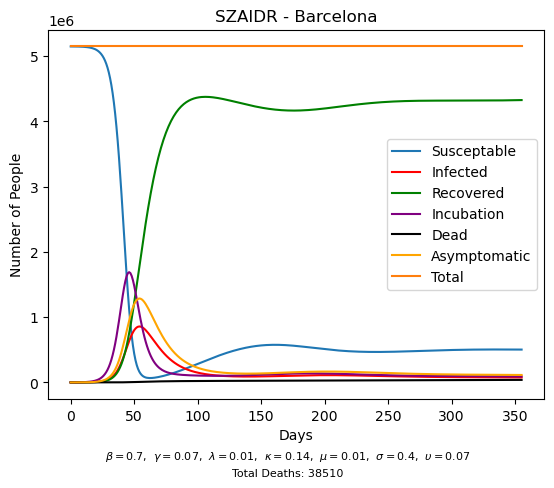

In [46]:
# infect people - intial condition
test_city = cities_exp['BCN']
test_city.reset_city()
test_city.infect(1000)

beta = 0.7
gamma = 0.07
lambda_0 = 1/90
kappa = 1/7
mu = .01
sigma = .4
upsilon = 0.07

t,s,z,a,i,d,r = ([] for i in range(7))
total_i= 0
total = []
for n in range(356 * 1):
    t.append(n)
    s.append(test_city.S)
    z.append(test_city.Z)
    a.append(test_city.A)
    i.append(test_city.I)
    d.append(test_city.D)
    r.append(test_city.R)
    total.append(test_city.S + test_city.Z + test_city.A + test_city.I + test_city.D + test_city.R)

    total_i += kappa * test_city.Z

    test_city = step_SZAIDR(test_city, beta, gamma, lambda_0 * (0.5 ** (total_i / test_city.population)), kappa, mu, sigma, upsilon, 1)

plot_SIR(f"SZAIDR - Barcelona", t, s, i, r, z, d, total, a, values={r'\beta': beta, r'\gamma': gamma, r'\lambda': lambda_0, r'\kappa': kappa, r'\mu': mu, r'\sigma': sigma, r'\upsilon': upsilon})

Anschließend werden auch alle anderen Funktionen erweitert, um das Modell durch ganz Europa laufen lassen zu können.

In [23]:
def calculate_travel_exp_restrictions (ci : ExpCity, ds, dz, da, di, dr):
    # Calculate a travel step for given city
    sumS = 0
    sumZ = 0
    sumA = 0
    sumI = 0
    sumR = 0

    deg_i = 0
    
    if ci.airport_closed:
        return 0,0,0,0,0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities_exp[iata]
        
        if cj.airport_closed:
            continue

        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumZ += n * cj.Z - ci.Z
        sumA += n * cj.A - ci.A
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R
        
        deg_i += 1
    
    # ensure there is no division by 0
    if deg_i == 0:
        deg_i = 1
    return (ds * sumS / deg_i, dz * sumZ / deg_i, da * sumA / deg_i, di * sumI / deg_i, dr * sumR / deg_i)

In [25]:
def combined_simulation_exp_restrictions (beta, gamma, lambda_0, kappa, mu, sigma, upsilon, ds, dz, da, di, dr, days, close_p, open_p):
    
    SZAIDRC_values = {}
    num_cases = {}
    for c in cities_exp:
        SZAIDRC_values[c] = []
        num_cases[c] = cities_exp[c].Z
    t = [0]
    temp_values = {}

    # add initial state
    for c in cities_exp.values():
        SZAIDRC_values[c.IATA].append((c.S, c.Z, c.A, c.I, c.D, c.R, False))
        
    for i in range(days):
         # sir dynamic
        for c in cities_exp.values():
            c.handle_restrictions(close_p, open_p)
            c = step_SZAIDR(c, beta, gamma,lambda_0 * (0.5 ** (num_cases[c.IATA] / c.population)), kappa, mu, sigma, upsilon, 1)
            
        # travel diffusion - don't apply it yet
        for c in cities_exp.values():    
            diff_S, diff_Z, diff_A, diff_I, diff_R = calculate_travel_exp_restrictions(c, ds, dz, da, di, dr)
            temp_values[c.IATA]=(c.S + diff_S,c.Z + diff_Z, c.A + diff_A, c.I + diff_I, c.D, c.R + diff_R, c.airport_closed)
        # apply the values
        for c in cities_exp.values():
            (c.S, c.Z, c.A, c.I, c.D, c.R, c.airport_closed) = temp_values[c.IATA]
            SZAIDRC_values[c.IATA].append(temp_values[c.IATA])
        t.append(i+1)    
    return t, SZAIDRC_values

In [21]:
def plot_state_exp_restrictions(ax, SZAIDRC, day, show_routes=False):
    
    for i, city in enumerate(SZAIDRC):
        S, Z, A, I, D, R, Closed = SZAIDRC[city][day]
        N = (S + Z + A + I + D + R)
        infection_percent = (I + A) / N
        # update markers
        marker = city_markers[i]
        
        color = (I/N, R/N, S/N)
        brightness = 1 - D/N
    
        marker.set(color = tuple([c* brightness for c in color]))
        marker.set_markersize(2 + 2 * (infection_percent + D/N))

        if (not show_routes):
            continue
        
        if len(closed_markers) > i:
            closed_marker = closed_markers[i]
            closed_marker.set(alpha = (.8 if Closed else 0))

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Zj, Aj, Ij, _, Rj, Closed_j = SZAIDRC[list(SZAIDRC.keys())[j]][day]
            Nj = Sj + Zj + Aj + Ij + Rj
            diff_percent = 0 if Closed or Closed_j else abs(N/Nj * (Aj+Ij - I - A)) / (N)
            line.set(alpha = min(1, diff_percent * 0.05))
        
            

## 7.2 Test des SZAIDR-Modells mit Flughafenschließungen

Im Folgenden werden Simulationsparameter aus dem Verhalten der Covid-19 Pandemie verwendet um das Verhalten unseres Modells zu testen. Dazu werden die Parameter aus der ursprünglichen Variante (1. Welle) verwendet: $R_0=3$, Inkubationszeit 5,8 Tage, Manifestationsindex (Anzahl der Infizierten die tatsächlich erkranken) etwa 70 $\%$, Fall-Verstorbenen-Anteil 1,8 $\%$, Antikörper mehrere Monate nachweisbar, Krankheitsdauer stark von Verlauf abhängig (etwa 10 Tage ab Symptombeginn).

Quelle: https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Steckbrief.html?nn=13490888#doc13776792bodyText1

In [19]:
beta = 0.3
gamma = 1/10
lambda_0 = 1/90
kappa = 0.17
mu = 0.018
sigma = 0.7
upsilon = 1/8

Die Parameter wurden hier möglichst realistisch gewählt. Während die Inkubationszeit ($\kappa$), die Todesrate ($\mu$) und die Manifestationsrate ($\sigma$) direkt aus den Werten des RKI's übernommen werden konnten, musste vor allem für die Krankheitsdauer geschätzt werden. Es wird dabei davon ausgegeangen, dass symptomatische Personen im Mittel 10 Tage ($\gamma$) und asymptomatische Personen nur etwa 8 Tage ($\upsilon$) krank sind. Aus $\gamma$ lässt sich dann mithilfe von $R_0$ auch die Ansteckungsrate $\beta$ bestimmen.

Nun wird die Ausbreitung der Krankheit durch Europa mithilfe einer Animation visualisiert. Dabei wird zugleich die Maßnahme der Flughafenschließungen implementiert, wobei die Flughäfen geschlossen werden, wenn über 5 $\%$ der jeweiligen Stadt infiziert sind und erst wieder geöffnet werden, wenn diese Zahl unter 2 $\%$ fällt. Die Sichbarkeit der Routen ist abhängig von der Anzahl der Infizierten, die sich über die jeweilige Route ausbreitet. Flughafenschließungen erkennt man also daran, dass die Routen von einem Tag auf den anderen unsichtbar werden. Dann sind dort keine Reisen mehr möglich.

In [26]:
cure_humanity_exp()
city = cities_exp['LIS']
city.infect_percent(.1)
days = 150
t, SZAIDRC_values = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, .05, .02)

create_infection_progress_animation(SZAIDRC_values, plot_state_exp_restrictions, days, "SZAIDR with travel restrictions", True, True)

saved


Die Animation zeigt schön wie die Flughafenschließungen die Ausbreitung verlangsamen. Lisabon wird schnell als Ausbreitungsherd erkannt und vom restlichen Europa abgeschnitten. Das kann allerdings nicht verhindern, dass bereits genügend infizierte in Europa verteilt sind, sodass sich das Infektionsgeschehen nach einer gewissen Verzögerung über ganz Europa ausbreitet. 

Allerdings ist über die Animation kein direkter Vergleich zwischen der Ausbreitung mit und ohne Flughafenschließungen möglich. Deshalb wird nun das Infektionsgeschehen für Frankfurt und ganz Europa für beide Varianten geplottet.

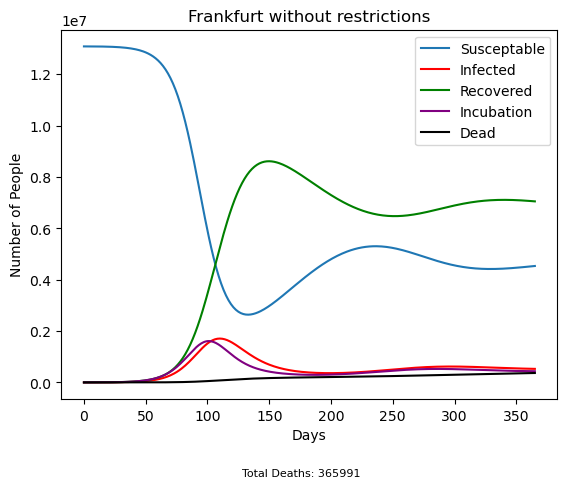

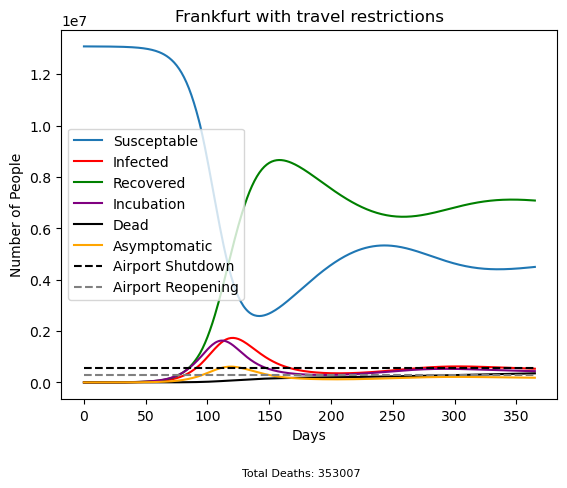

In [27]:
cure_humanity_exp()
city = cities_exp['LIS']
city.infect_percent(.1)
days = 365
gamma = 0.1
t, SZAIDRC_values_no_res = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, 2, 2)
S, Z, A, I, D, R, Closed = zip(*SZAIDRC_values_no_res['FRA'])
plot_SIR(f"Frankfurt without restrictions", t, S, I, R, Z, D)

cure_humanity_exp()
city = cities_exp['LIS']
city.infect_percent(.1)
t, SZAIDRC_values = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, .05, .02)
S, Z, A, I, D, R, Closed = zip(*SZAIDRC_values['FRA'])
plot_SIR(f"Frankfurt with travel restrictions", t, S, I, R, Z, D, a=A, open=0.05 * city.population, close=0.1 * city.population)
plt.close()

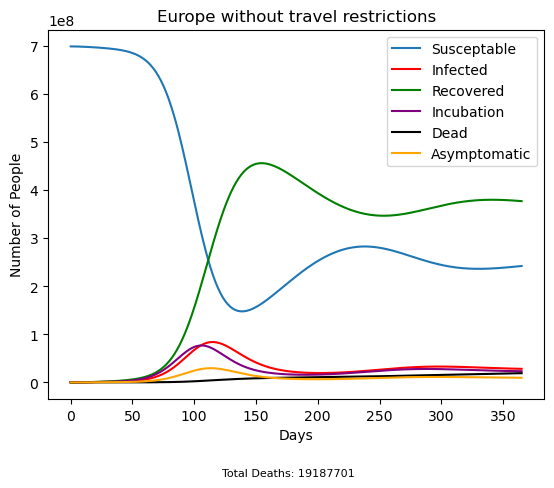

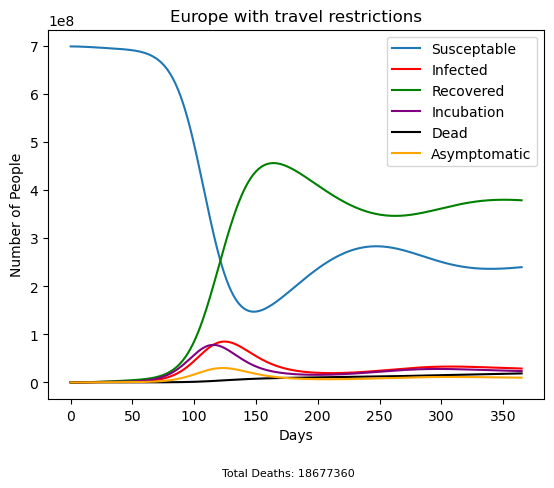

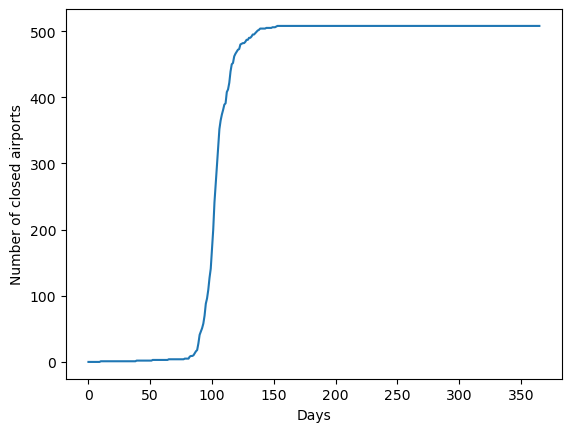

In [28]:
plot_global_values("Europe without travel restrictions", t, SZAIDRC_values_no_res)
plot_global_values("Europe with travel restrictions", t, SZAIDRC_values)

Beim Vergleich fällt auf, dass die Flughafenschließungen nicht sehr effektiv sind. Insgesamt können sie aber ein paar Tote in Europa verhindern und vor allem die Ausbreitungsgeschwindigkeit etwas verlangsamen. In Frankfurt ist der Peak der Infektionszahlen etwa 30 Tage später. In Verbindung mit anderen Maßnahmen, kann so also etwas Zeit gewonnen werden. Die Reisebeschränkungen sind deswegen so wenig effektiv die Zahlen insgesamt einzudämmen, da bereits eine einzige Infizierte Person in einer Stadt ausreicht, um die Welle zu starten und die Reisebewegung nur einen sehr geringen Anteil der Infektionen verteilt.

Interessant ist also der zeitliche Vergleich der Peaks. Im Folgenden wird der Zeitpunkt des Peaks der Infektionszahlen für verschiedene Flughafenschließungsgrenzen und Wahrscheinlichkeiten für einen asymptomitischen Verlauf betrachtet.

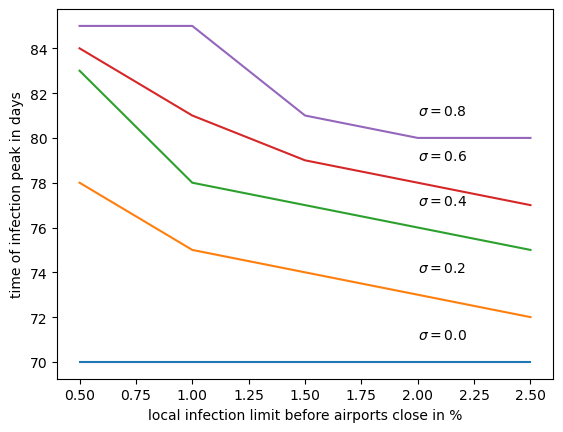

In [ ]:
cure_humanity_exp()
days = 150

for sigma_change in np.arange(0, .9, .2):
    infection_peaks = []
    close_percent = []
    for x in np.arange(0.005, 0.03, 0.005):
        cure_humanity_exp()
        city = cities_exp['KIV']
        city.infect_percent(.1)
        t, SZAIDRC_values = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma_change, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, x, x/2)
        global_i_values = []
        # build sum over all values from each city for each timestep
        for d in range(len(t)): 
            sum_i = 0
            for i, v in enumerate(SZAIDRC_values.values()):
                sum_i += v[d][3]
                sum_i += v[d][2]
            global_i_values.append(sum_i)
        
        close_percent.append(x * 100)
        infection_peaks.append(global_i_values.index(max(global_i_values)))
        
    plt.plot(close_percent, infection_peaks)
    plt.annotate(fr'$\sigma = {round(sigma_change, 2)}$', xy=[2, infection_peaks[3] + 0.2])
plt.xlabel('local infection limit before airports close in %')
plt.ylabel('time of infection peak in days')
plt.show()

$\sigma$ ist der Manifestationsindex, also wie viele der Infizierten auch tatsächlich symptomatisch erkranken. Wie man aus der Grafik sehen kann, ist ein kleineres Limit der symptomatitschen Infektionszahlen bevor Flughäfen geschlossen werden effektiver darin die Ausbreitung zu verlangsamen. Je geringer allerdings der Manifestationsindex $\sigma$ ist, desto später werden Flughäfen geschlossen, wie man an den früheren Peaks sehen kann. Bei einem $\sigma$ von 0, schließen die Flughäfen gar nicht mehr, da die Kranheit völlig unendeckt bleibt. Ein solches Virus kann besonders gefährlich sein, sollte es nach langer Zeit Symptome aufzeigen, da es sich ungehindert ausbreiten kann, schwer zu entdecken ist.

# 8 Erweiterung auf die ganze Welt

Jetzt kann das Modell natürlich auch auf Daten aller Flughäfen weltweit ausgeführt werden. Die Laufzeit ist dann selbstverständlich deutlich länger.

In [31]:
# mr. worldwide 
airports = pd.read_csv('./datasets/cleaned_data/airports_cleaned_world_wide.csv')
routes = pd.read_csv('./datasets/cleaned_data/routes_cleaned_world_wide.csv')
routes_matrix = pd.read_csv('./datasets/cleaned_data/routes_matrix_cleaned_world_wide.csv', index_col=0)

In [32]:
# create a new worlwide dict with iata to cities
cities_exp = {}
for airport in (airports[['population', 'IATA']]).values:
    cities_exp[airport[1]] = (ExpCity(airport[0], airport[1]))

cities = cities_exp

Als Beispiel starten wir unsere Covid-19 ähnliche Krankheit in Wuhan und gucken uns den Verlauf mit und ohne Reisebeschränkungen an.

In [ ]:
cure_humanity_exp()
city = cities_exp['WUH']
city.infect_percent(.1)
days = 200
t, SZAIDRC_values = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, 2, 2)

plot_global_values("Covid-19 - World without travel restrictions", t, SZAIDRC_values)

In [47]:
#create_infection_progress_animation(SZAIDRC_values, plot_state_exp_restrictions, days, "Covid-19 without travel restrictions world wide", True, False)
display(Image(url=f'figures/{"Covid-19 World without Restrictions"}.png'))
display(Image(url=f'figures/{"Covid-19 without travel restrictions worldwide"}.gif'))

In [ ]:
cure_humanity_exp()
city = cities_exp['WUH']
city.infect_percent(.1)
days = 200
t, SZAIDRC_values = combined_simulation_exp_restrictions(beta, gamma, lambda_0, kappa, mu, sigma, upsilon, 0.01, 0.01, 0.01, 0.01, 0.01, days, .05, .02)

plot_global_values("Covid-19 - with travel restrictions", t, SZAIDRC_values)

In [43]:
#create_infection_progress_animation(SZAIDRC_values, plot_state_exp_restrictions, days, "Covid-19 with travel restrictions world wide", True, True)
display(Image(url=f'figures/{"Covid-19 world with travel restrictions"}.png'))
display(Image(url=f'figures/{"Covid-19 with travel restrictions world wide"}.gif'))

# 9 Fazit

Als Fazit zu unserem Projekt lässt sich zusammenfassen, dass wir eine kompakte und wirksame Weise gefunden haben, um die gegebenen Aufgaben zu erfüllen. Durch die Simulationen mit dem SIR-Modell hat sich gezeigt, dass bereits bei dieser einfachen Darstellung relevante Aspekte der Krankheiten und deren Verläufen sichtbar wird. In den erweiternden Aufgaben haben wir auf die Verbesserung des SIR-Modells fokussiert und in Kombination dazu einige mögliche Maßnahmen zur Epidemieeinschränkung implimentiert. Um das Modell realistischer zu gestalten haben wir einige zusätzliche Personengruppen hinzugefügt und eine Wiederansteckung mit dem Krankheitserreger ermöglicht. Aufgrund dessen ist nun eine genauere Definition der Krankheit sowie eine detailliertere Beobachtung der möglichen Einschränkungsmaßnahmen möglich. Wie im Dokument zu sehen wurden die von uns implimentierten Modifikationen mit erfolgreich getestet und analysiert. Unser Code lässt ließ sich ebenfalls einfach auf ein größeres Gebiet mit mehr Städten und Verbindungen erweitern, wie es hier bei einem globalen Modell der Fall war.